## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-agriVision-fourier-gray' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\fourier\\approx1e5\\gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta

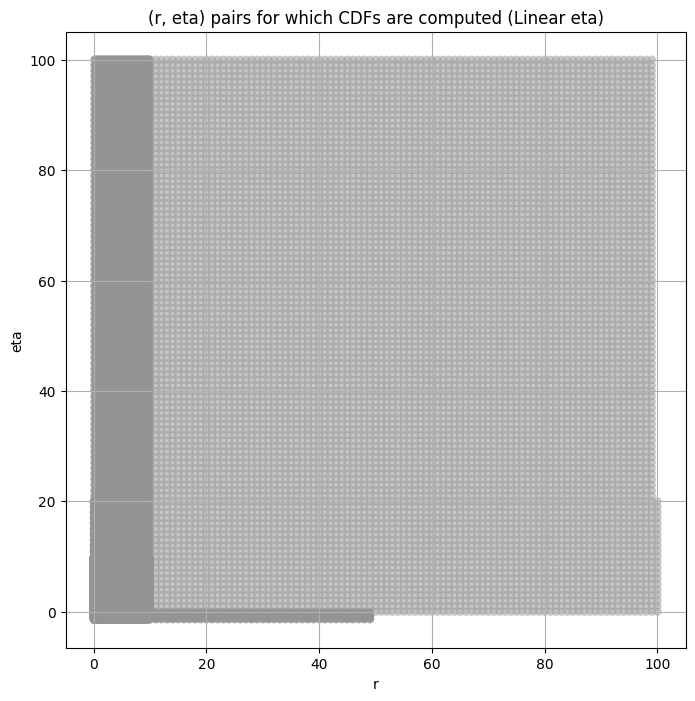

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:44<00:00, 960.48it/s]


Band 5


100%|██████████| 100000/100000 [01:47<00:00, 925.98it/s]


Band 8


100%|██████████| 100000/100000 [01:33<00:00, 1074.90it/s]


Band 11


100%|██████████| 100000/100000 [01:34<00:00, 1055.68it/s]


Band 14


100%|██████████| 100000/100000 [01:37<00:00, 1021.28it/s]


Band 17


100%|██████████| 100000/100000 [03:26<00:00, 484.53it/s]


Band 20


100%|██████████| 100000/100000 [03:33<00:00, 469.16it/s]


Band 23


100%|██████████| 100000/100000 [03:19<00:00, 501.84it/s]


Band 26


100%|██████████| 100000/100000 [03:31<00:00, 473.13it/s]


Band 29


100%|██████████| 100000/100000 [03:29<00:00, 478.01it/s]


Band 32


100%|██████████| 100000/100000 [03:23<00:00, 490.45it/s]


obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  
band                             
2       600.4443        45000.0  
5      2060.5480       117000.0  
8      1727.8018       189000.0  
11     6259.8403       495000.0  
14     4860.0464      1134000.0  
17     7685.5044      2574000.0  
20     6708.6846      5967000.0  
23     8285.5580     13887000.0  
26     9318.7330     31968000.0  
29     9072.5770     73701000.0  
32     3932.4010     59634000.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [09:44<00:00, 95.75it/s] 


Finding Minimum after computing 55966 CDFs
Number of samples: 45000, Without approximation : 45000.0


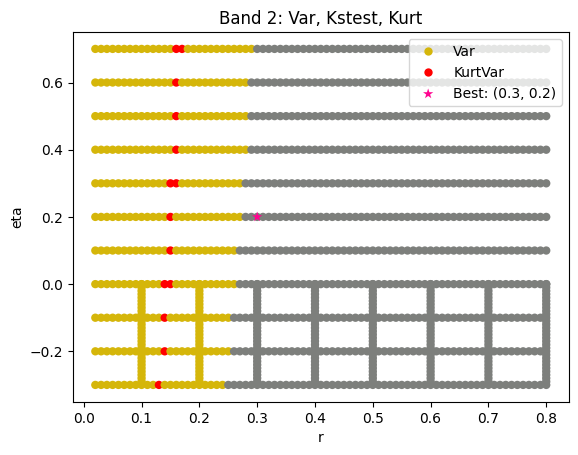

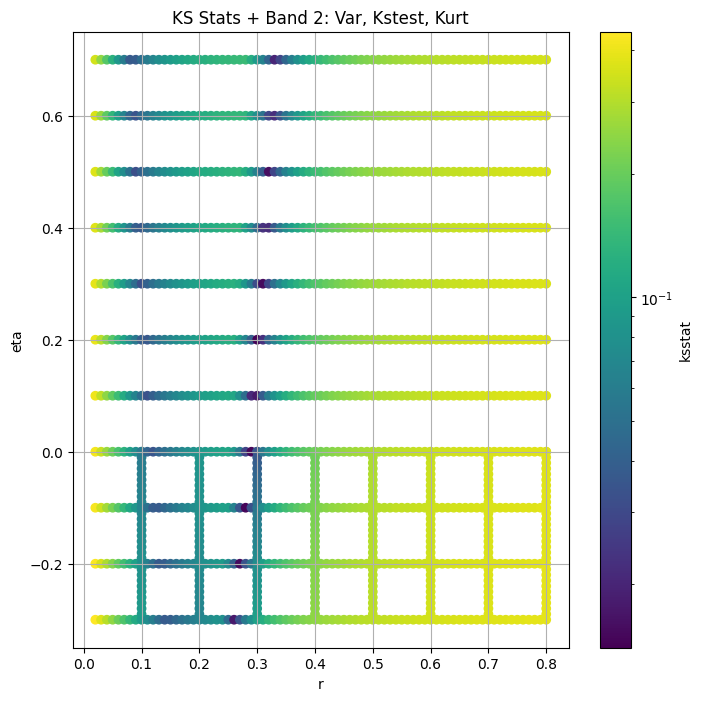

####
Band  5


100%|██████████| 55966/55966 [22:36<00:00, 41.26it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 117000.0


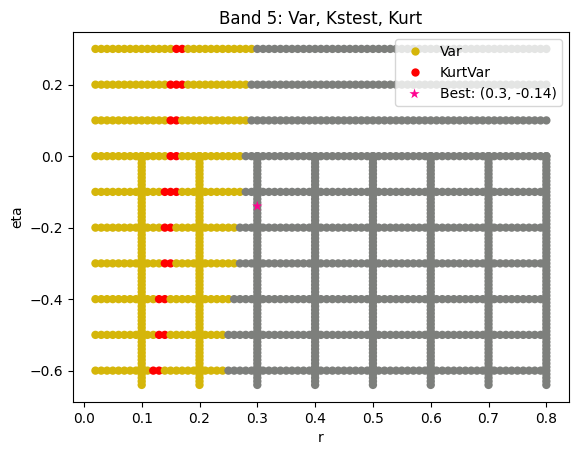

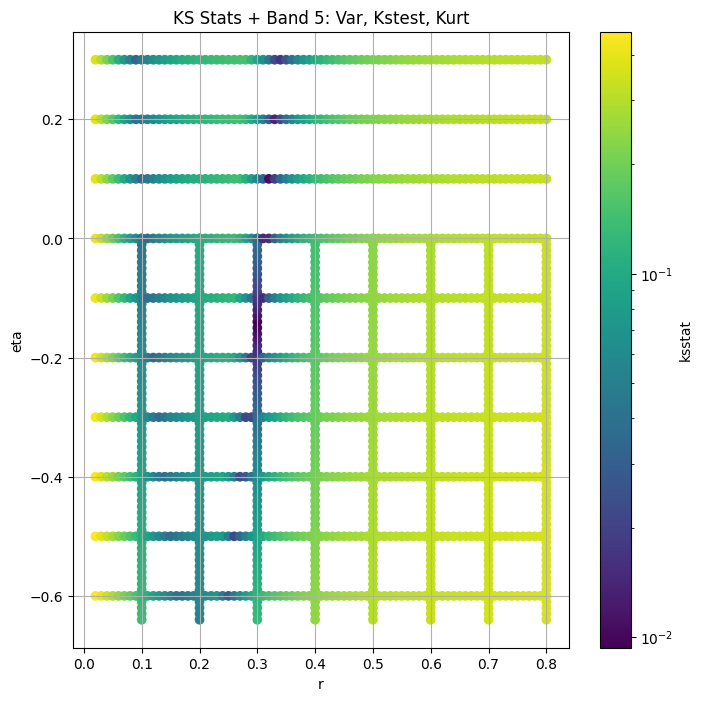

####
Band  8


100%|██████████| 55966/55966 [22:03<00:00, 42.28it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 189000.0


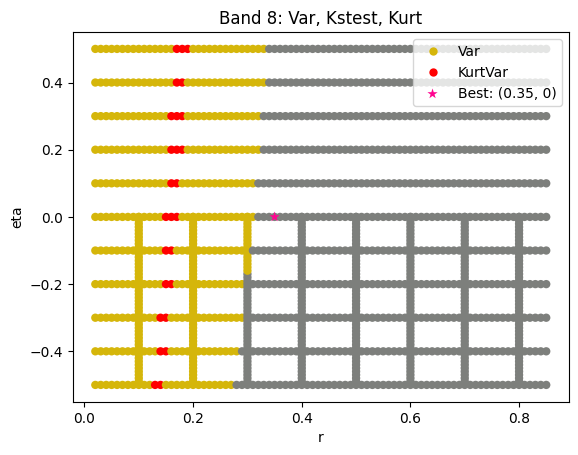

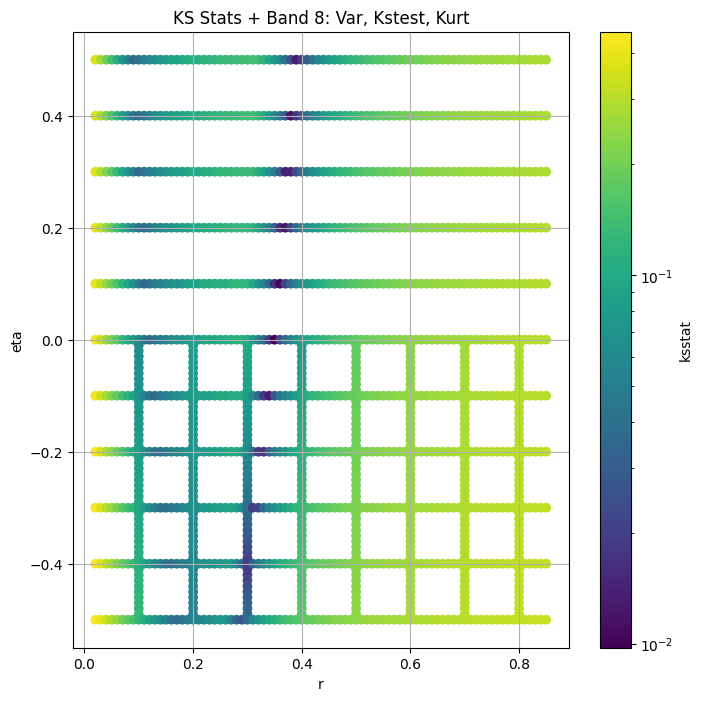

####
Band  11


100%|██████████| 55966/55966 [21:56<00:00, 42.50it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 495000.0


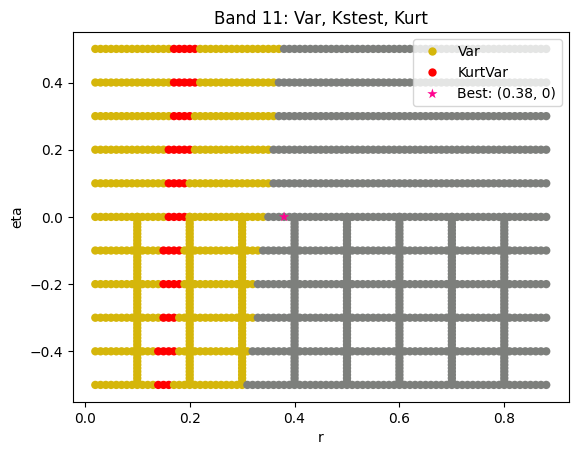

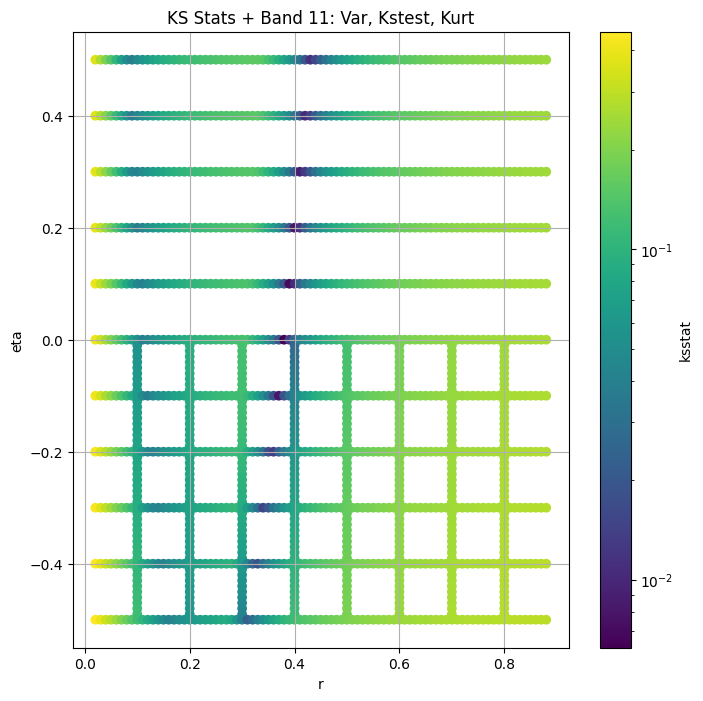

####
Band  14


100%|██████████| 55966/55966 [21:50<00:00, 42.72it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1134000.0


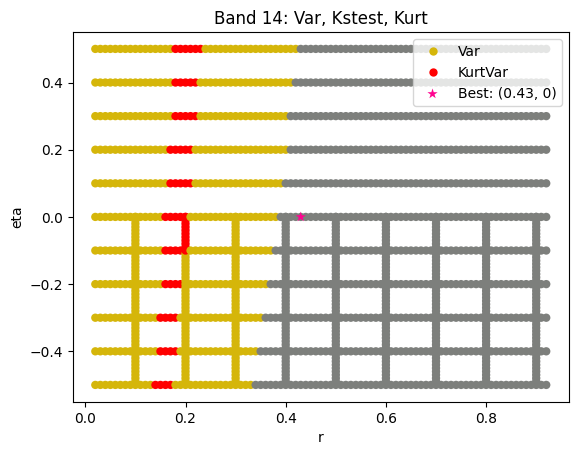

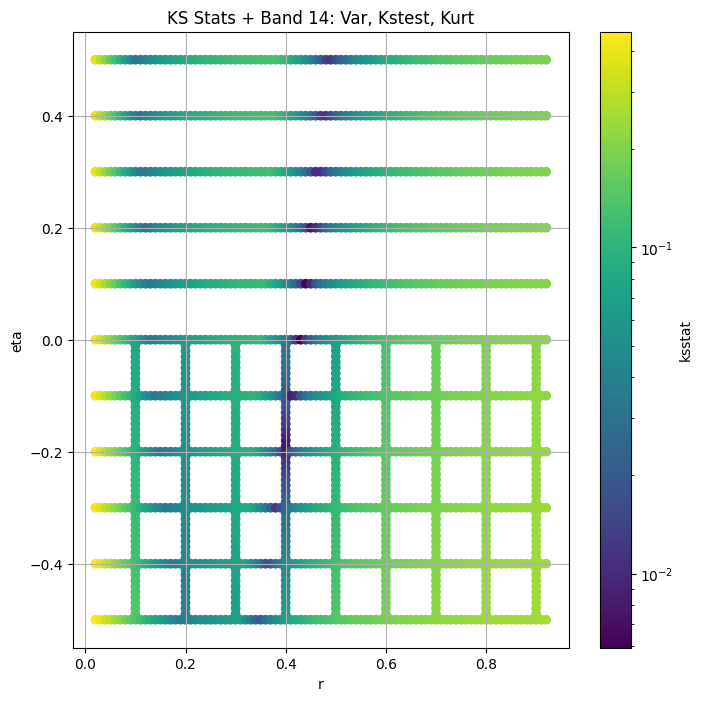

####
Band  17


100%|██████████| 55966/55966 [21:50<00:00, 42.72it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2574000.0


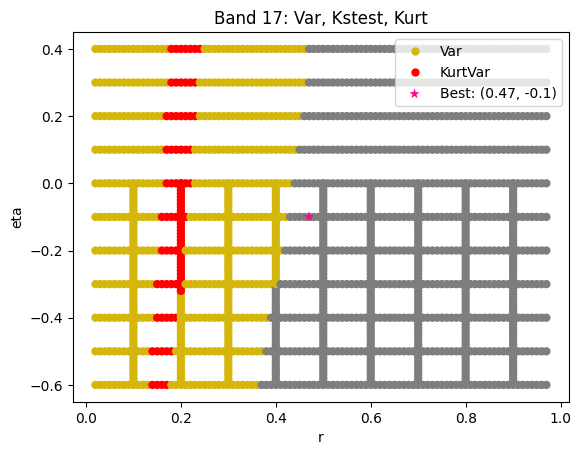

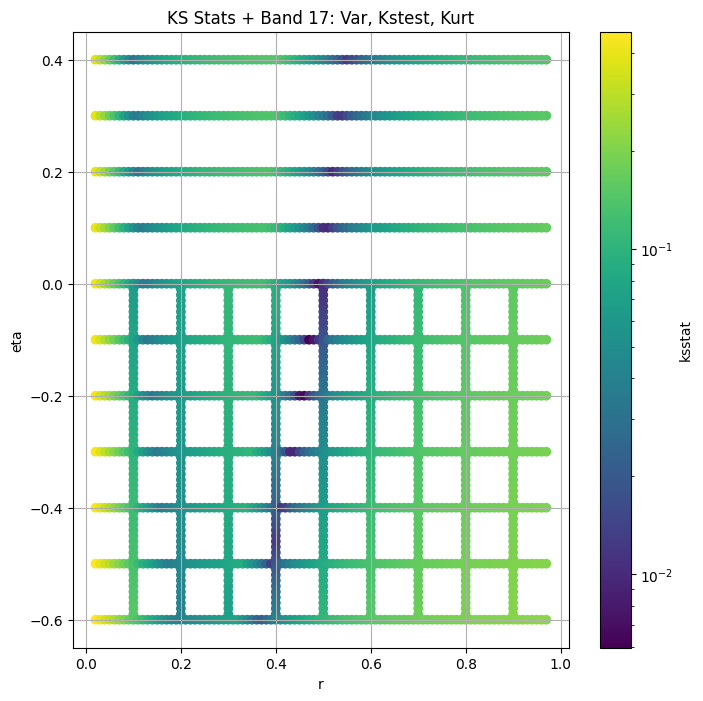

####
Band  20


100%|██████████| 55966/55966 [20:50<00:00, 44.75it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 5967000.0


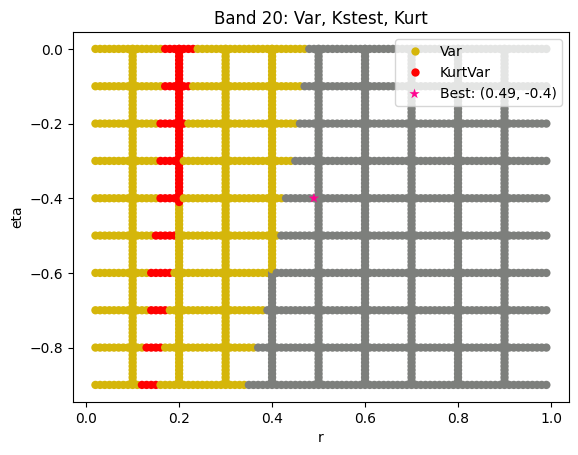

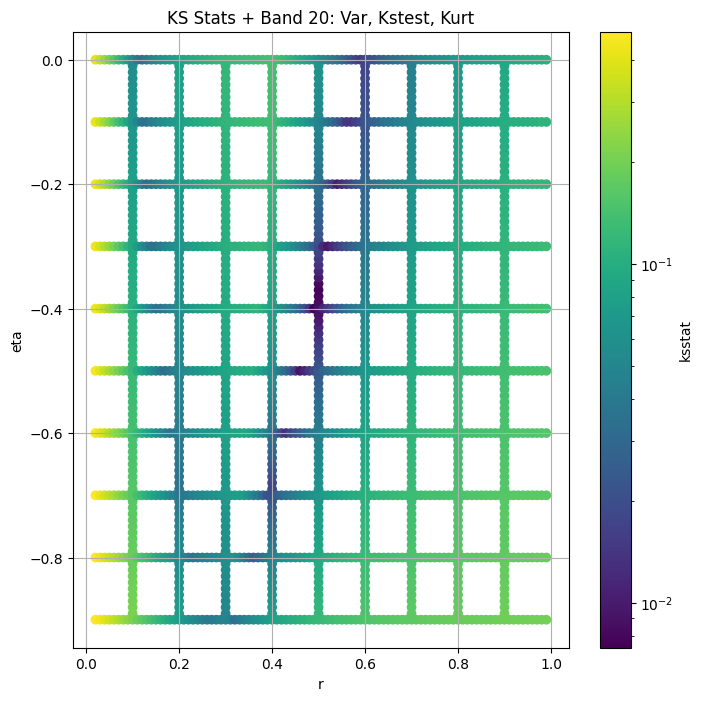

####
Band  23


100%|██████████| 55966/55966 [21:44<00:00, 42.89it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13887000.0


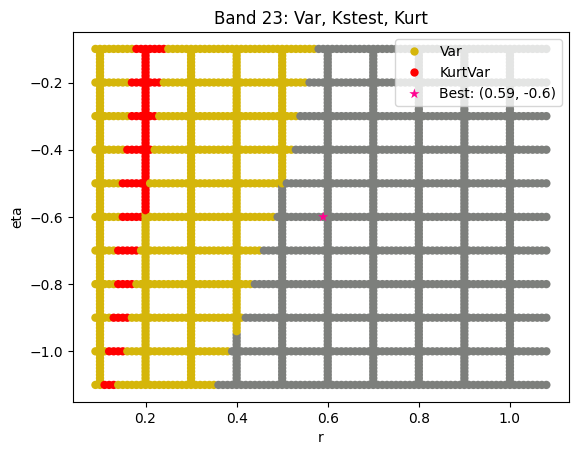

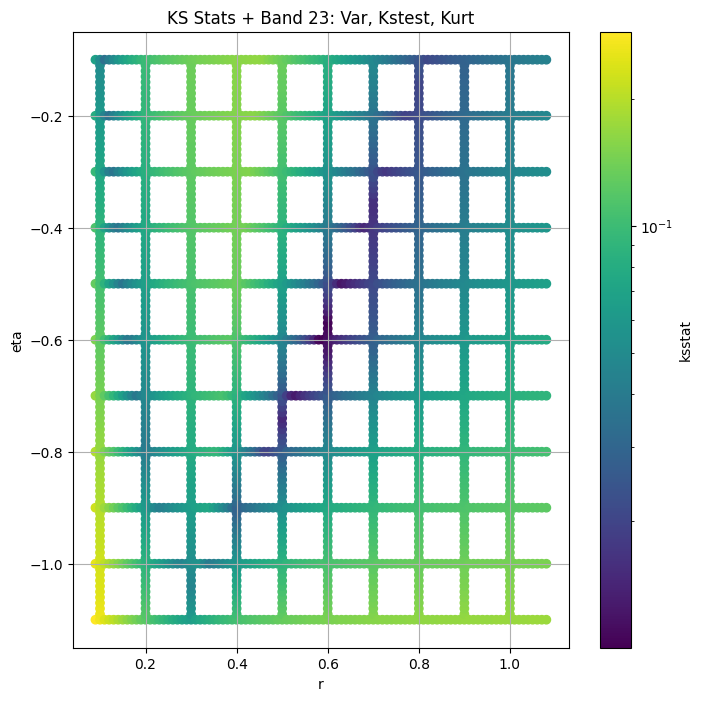

####
Band  26


100%|██████████| 55966/55966 [20:44<00:00, 44.96it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 31968000.0


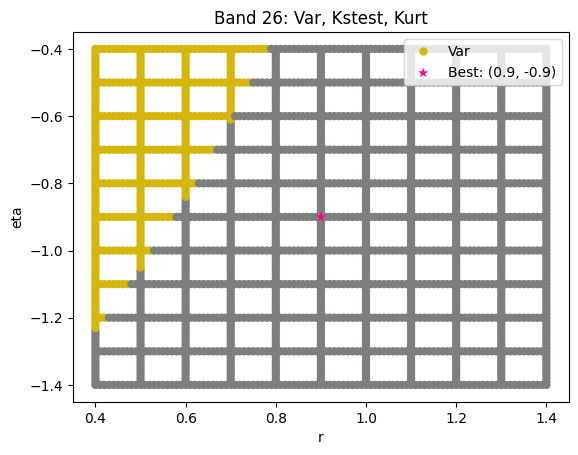

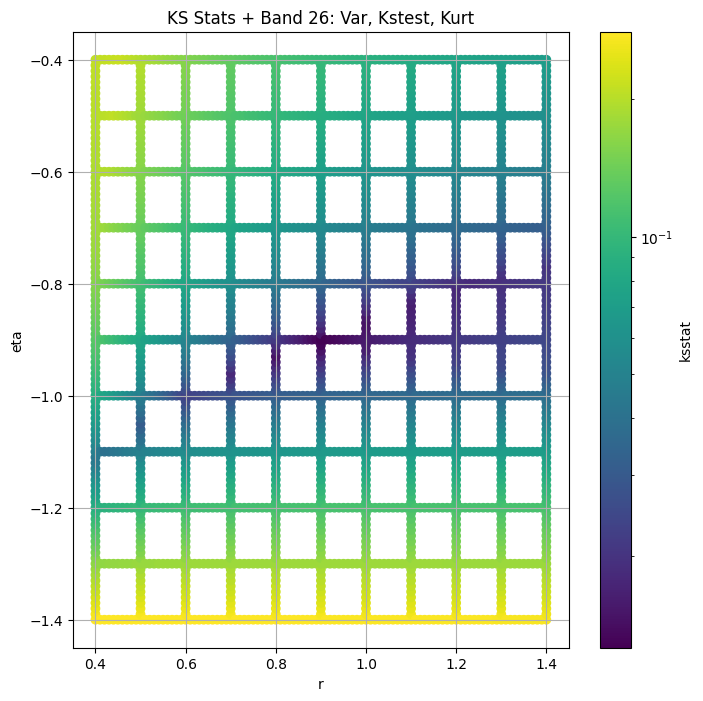

####
Band  29


100%|██████████| 55966/55966 [21:40<00:00, 43.05it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 73701000.0


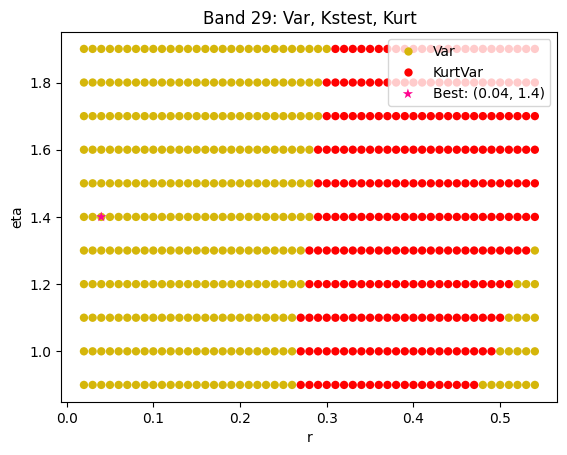

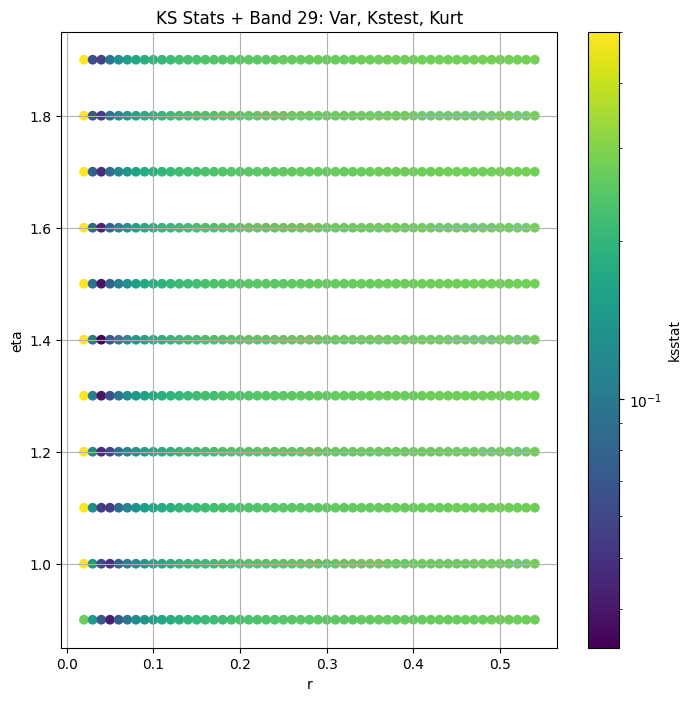

####
Band  32


100%|██████████| 55966/55966 [22:17<00:00, 41.85it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 59634000.0


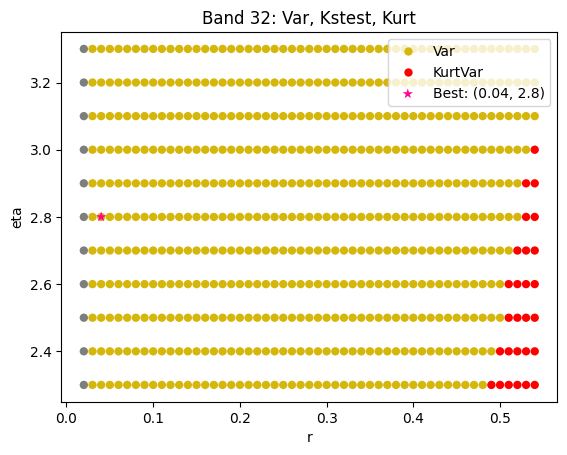

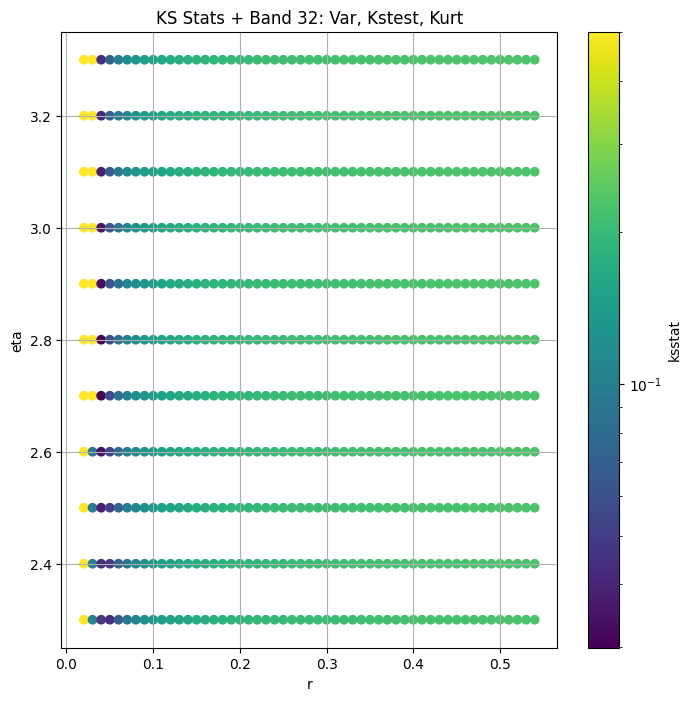

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       600.4443        45000.0       0.30         0.20   1.000000e+05   
5      2060.5480       117000.0       0.30        -0.14   1.000000e+05   
8      1727.8018       189000.0       0.35         0.00   1.000000e+05   
11     6259.8403       495000.0       0.38         0.00   1.000000e+05   
14     4860.0464      1134000.0       0.43         0.00   1.000000e+05   
17     7685.5044      2574000.0       0.47        -0.10   1.000000e+05   
20     6708.6846      5967000.0       0.49        -0.40   1.000000e+05   
23     8285.5580     13887000.0       0.59        -0.60   1.000000e+05   
26     9318.7330     31968000.0       0.90        -0.90   1.000000e+05   
29     9072.5770     73701000.0       0.04         1.40   8.263222e-44   
32     3932.4010     59634000.0       0.04         2.80   5.061535e-49   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.014012                 0.006398  
5                0.009347                 0.003969  
8                0.009754                 0.003123  
11               0.006223                 0.001930  
14               0.005925                 0.001275  
17               0.005949                 0.000846  
20               0.007364                 0.000556  
23               0.010036                 0.000364  
26               0.012586                 0.000240  
29               0.033704                 0.000158  
32               0.029953                 0.000176

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:03<00:00, 93.12it/s] 


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 38.78it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 38.13it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 35.28it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 35.12it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 36.43it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 39.02it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:09<00:00, 39.51it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       600.4443        45000.0       0.30         0.20   1.000000e+05   
5      2060.5480       117000.0       0.30        -0.14   1.000000e+05   
8      1727.8018       189000.0       0.35         0.00   1.000000e+05   
11     6259.8403       495000.0       0.38         0.00   1.000000e+05   
14     4860.0464      1134000.0       0.43         0.00   1.000000e+05   
17     7685.5044      2574000.0       0.47        -0.10   1.000000e+05   
20     6708.6846      5967000.0       0.49        -0.40   1.000000e+05   
23     8285.5580     13887000.0       0.59        -0.60   1.000000e+05   
26     9318.7330     31968000.0       0.90        -0.90   1.000000e+05   
29     9072.5770     73701000.0       0.04         1.40   8.263222e-44   
32     3932.4010     59634000.0       0.04         2.80   5.061535e-49   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.014012                 0.006398         0.36   
5                0.009347                 0.003969         0.36   
8                0.009754                 0.003123         0.35   
11               0.006223                 0.001930         0.38   
14               0.005925                 0.001275         0.43   
17               0.005949                 0.000846         0.49   
20               0.007364                 0.000556         0.59   
23               0.010036                 0.000364         0.87   
26               0.012586                 0.000240         6.00   
29               0.033704                 0.000158         6.00   
32               0.029953                 0.000176         5.90   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2           47.550454          0.151043  
5           47.550454          0.084226  
8       100000.000000          0.009754  
11      100000.000000          0.006223  
14      100000.000000          0.005925  
17         314.108387          0.007456  
20         698.907411          0.014870  
23        2126.037470          0.023148  
26        7081.851683          0.076868  
29        7081.851683          0.254468  
32        7077.148189          0.361850

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.292, 0.17), 50 of 441
(0.294, 0.25), 100 of 441
(0.297, 0.12), 150 of 441
(0.299, 0.2), 200 of 441
(0.301, 0.28), 250 of 441
(0.304, 0.15), 300 of 441
(0.306, 0.23), 350 of 441
(0.309, 0.1), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 96.34it/s] 


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.295, 0.11), 0.01011025846514102)


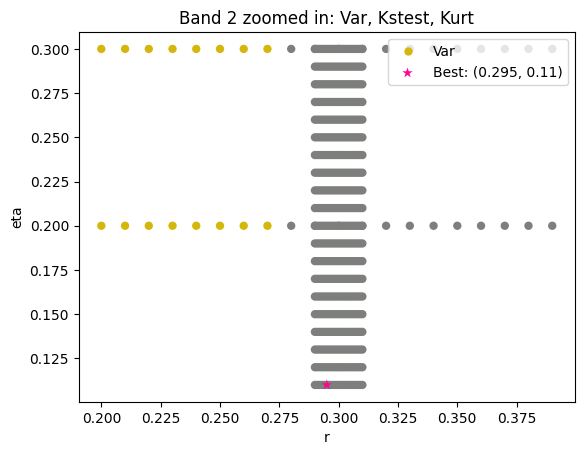

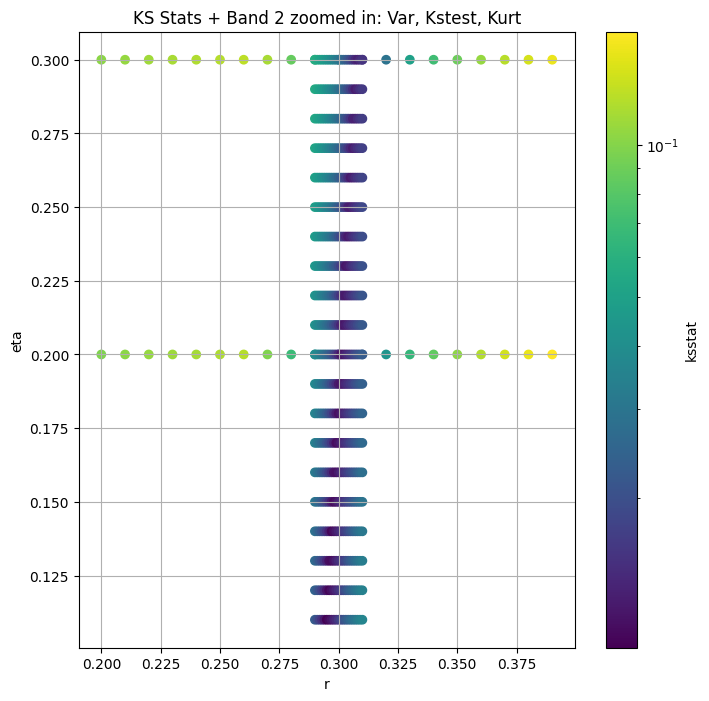

Band 5
(0.22, -0.143), 50 of 441
(0.24, -0.135), 100 of 441
(0.27, -0.148), 150 of 441
(0.29, -0.14), 200 of 441
(0.31, -0.132), 250 of 441
(0.34, -0.145), 300 of 441
(0.36, -0.137), 350 of 441
(0.39, -0.15), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 91.91it/s] 


Finding Minimum after computing 441 CDFs
Iter 1 band 5 best parameters: ((0.3, -0.142), 0.008934702565641162)


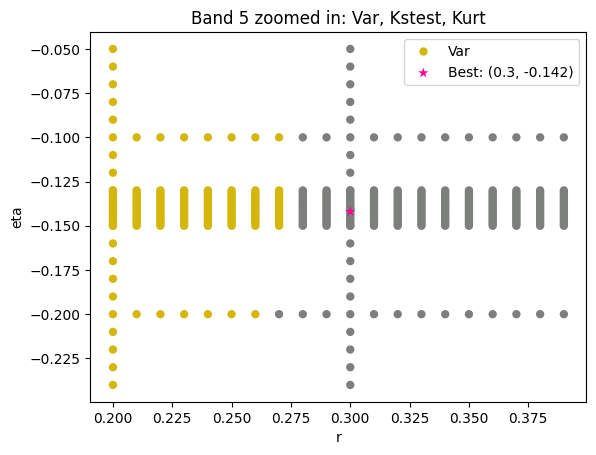

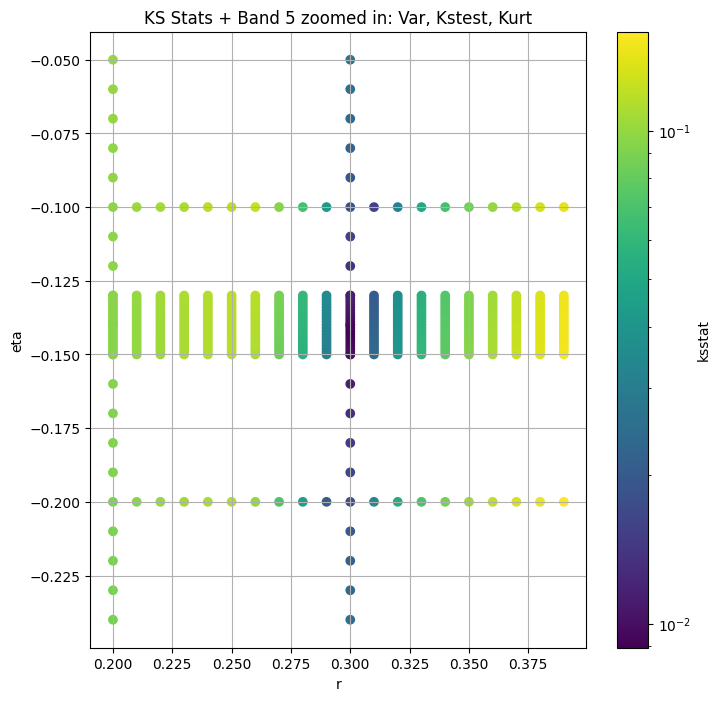

Band 8
(0.342, -0.01), 50 of 420
(0.344, 0.09), 100 of 420
(0.347, -0.01), 150 of 420
(0.349, 0.09), 200 of 420
(0.352, -0.01), 250 of 420
(0.354, 0.09), 300 of 420
(0.357, -0.01), 350 of 420
(0.359, 0.09), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 115.11it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.343, -0.04), 0.007821367453499817)


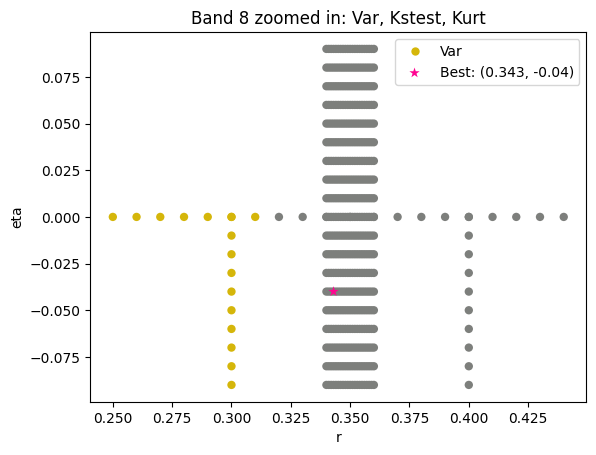

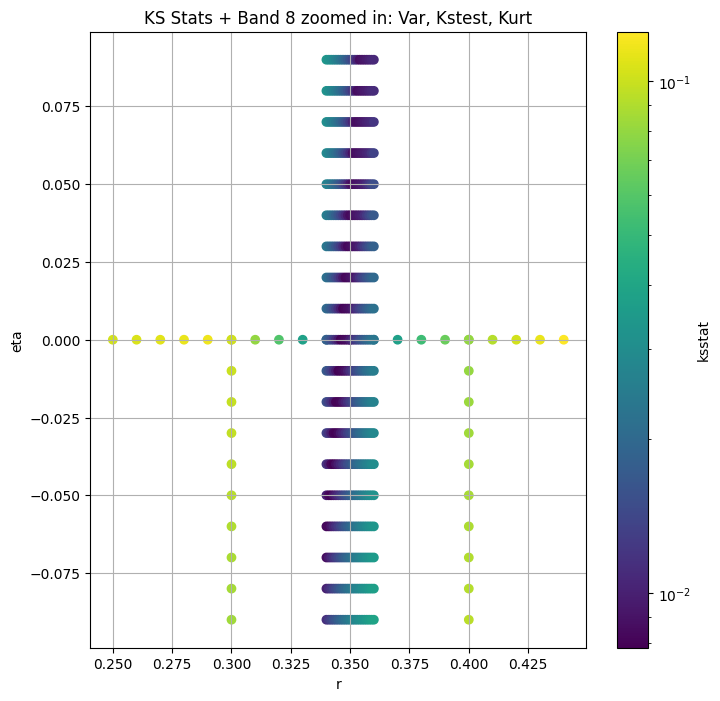

Band 11
(0.372, -0.01), 50 of 420
(0.374, 0.09), 100 of 420
(0.377, -0.01), 150 of 420
(0.379, 0.09), 200 of 420
(0.382, -0.01), 250 of 420
(0.384, 0.09), 300 of 420
(0.387, -0.01), 350 of 420
(0.389, 0.09), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 119.53it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.375, -0.05), 0.005919440888576544)


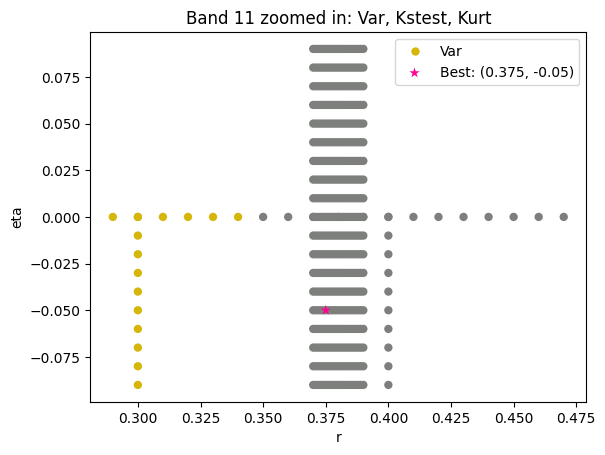

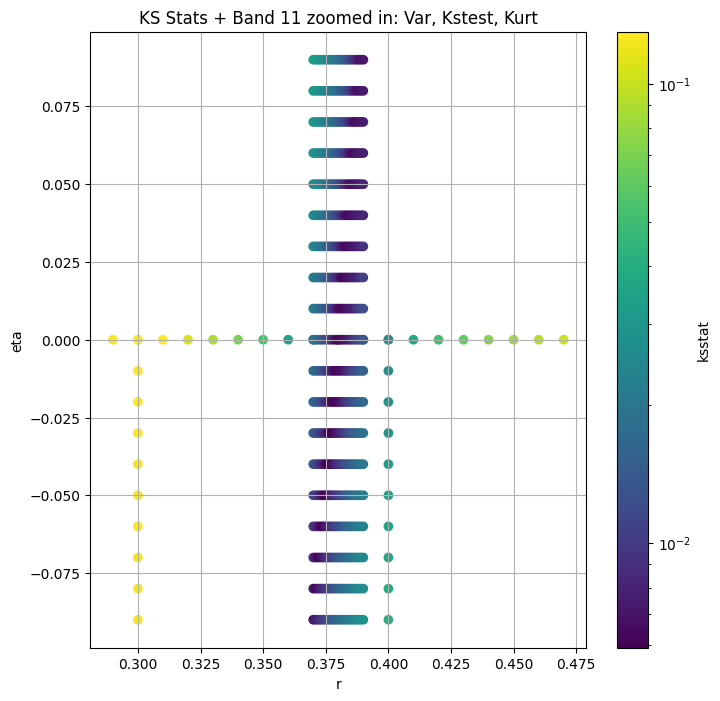

Band 14
(0.422, -0.01), 50 of 420
(0.424, 0.09), 100 of 420
(0.427, -0.01), 150 of 420
(0.429, 0.09), 200 of 420
(0.432, -0.01), 250 of 420
(0.434, 0.09), 300 of 420
(0.437, -0.01), 350 of 420
(0.439, 0.09), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 118.50it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.42, -0.05), 0.004869163239898611)


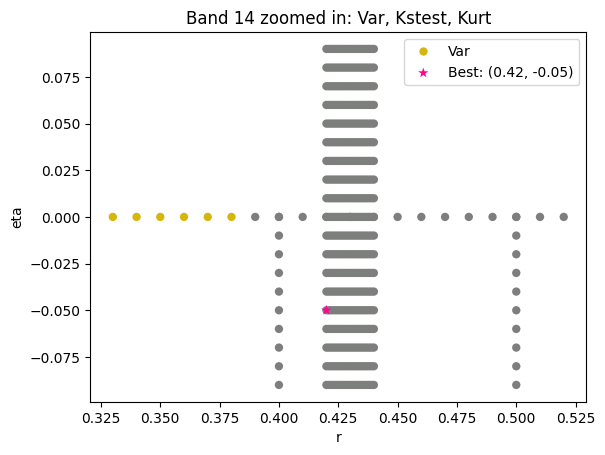

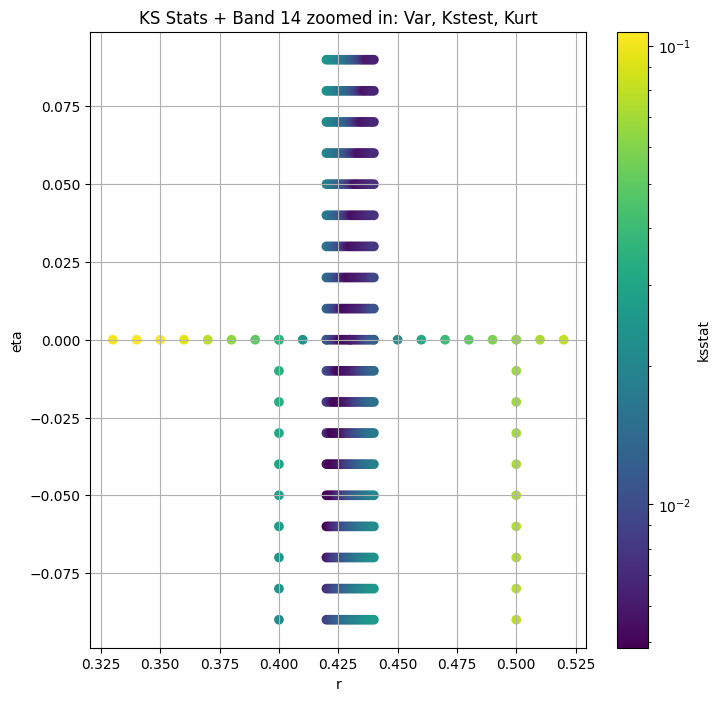

Band 17
(0.462, -0.11), 50 of 420
(0.464, -0.01), 100 of 420
(0.467, -0.11), 150 of 420
(0.469, -0.01), 200 of 420
(0.472, -0.11), 250 of 420
(0.474, -0.01), 300 of 420
(0.477, -0.11), 350 of 420
(0.479, -0.01), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 119.21it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.461, -0.16), 0.004940434132296883)


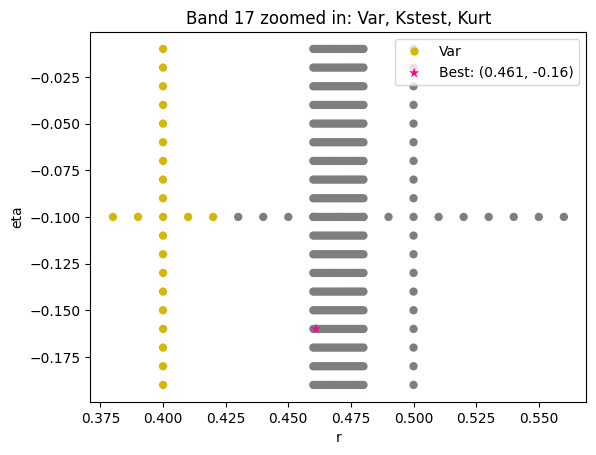

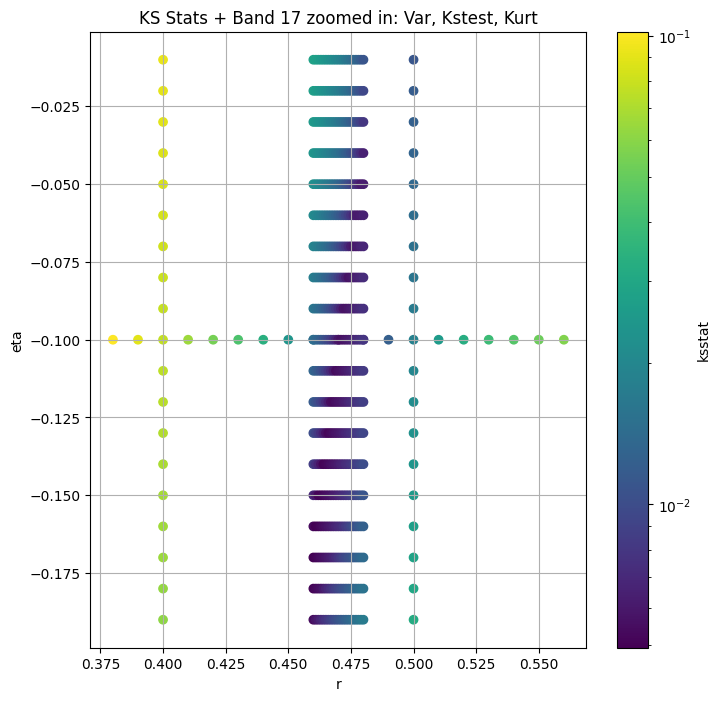

Band 20
(0.482, -0.41), 50 of 420
(0.484, -0.31), 100 of 420
(0.487, -0.41), 150 of 420
(0.489, -0.31), 200 of 420
(0.492, -0.41), 250 of 420
(0.494, -0.31), 300 of 420
(0.497, -0.41), 350 of 420
(0.499, -0.31), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 124.77it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.486, -0.42), 0.006442032906547121)


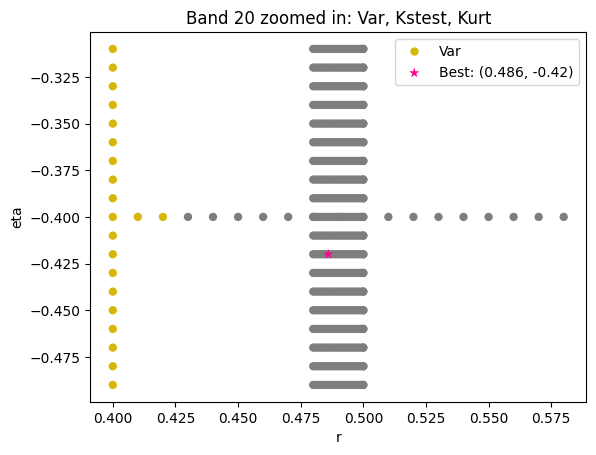

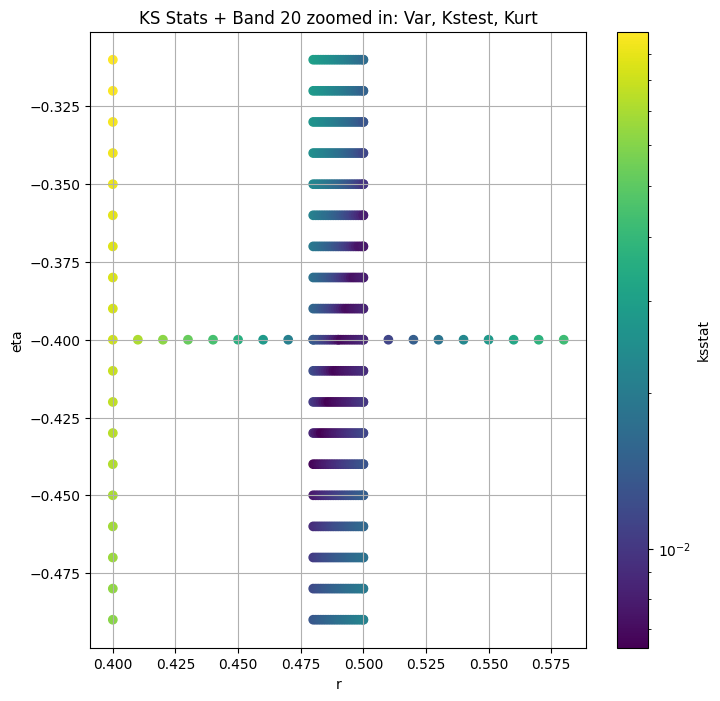

Band 23
(0.582, -0.61), 50 of 420
(0.584, -0.51), 100 of 420
(0.587, -0.61), 150 of 420
(0.589, -0.51), 200 of 420
(0.592, -0.61), 250 of 420
(0.594, -0.51), 300 of 420
(0.597, -0.61), 350 of 420
(0.599, -0.51), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 115.61it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.58, -0.61), 0.009092859874943127)


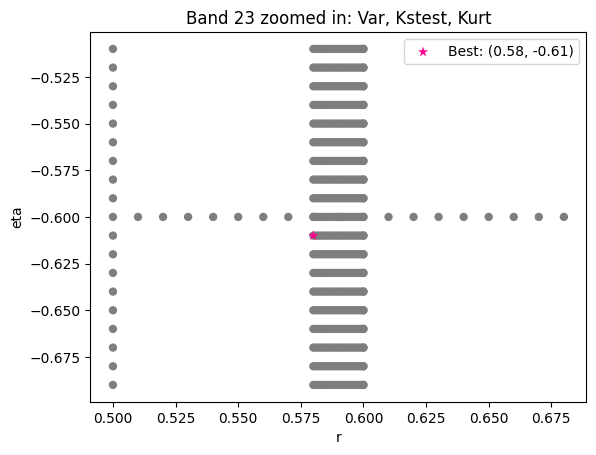

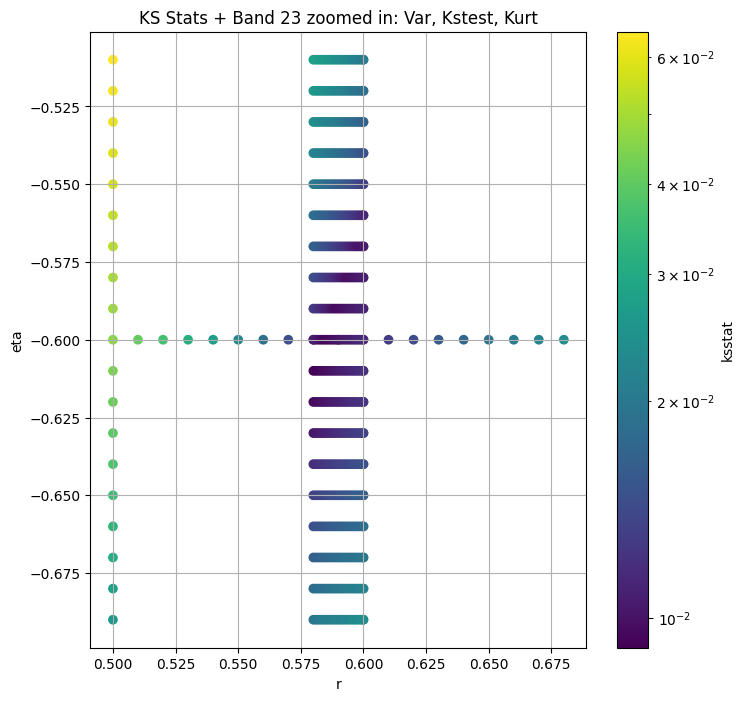

Band 26
(0.892, -0.903), 50 of 441
(0.894, -0.895), 100 of 441
(0.897, -0.908), 150 of 441
(0.899, -0.9), 200 of 441
(0.901, -0.892), 250 of 441
(0.904, -0.905), 300 of 441
(0.906, -0.897), 350 of 441
(0.909, -0.91), 400 of 441


100%|██████████| 441/441 [00:03<00:00, 112.67it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 26 best parameters: ((0.891, -0.905), 0.012096064450977329)


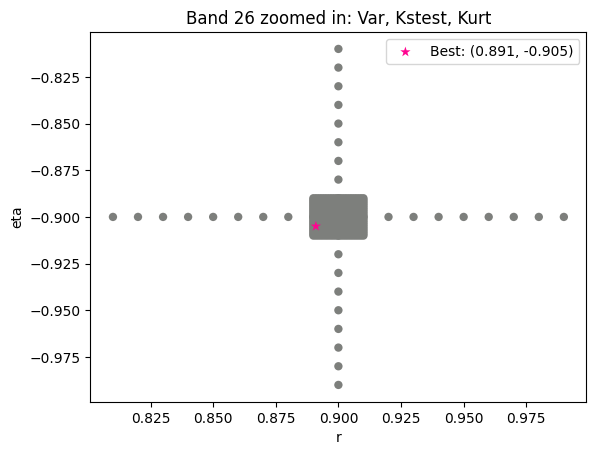

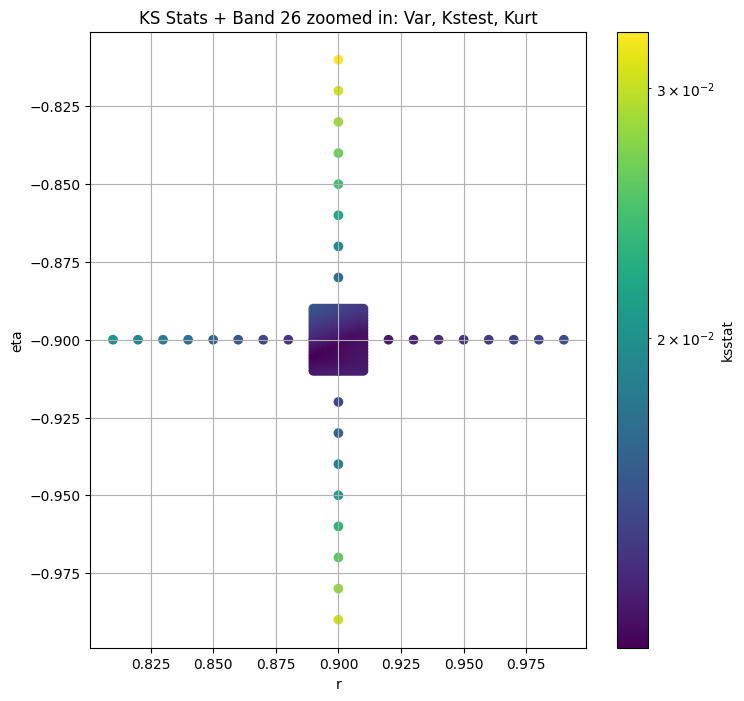

Band 29
(0.032, 1.37), 50 of 441
(0.034, 1.45), 100 of 441
(0.037, 1.32), 150 of 441
(0.039, 1.4), 200 of 441
(0.041, 1.48), 250 of 441
(0.044, 1.35), 300 of 441
(0.046, 1.43), 350 of 441
(0.049, 1.3), 400 of 441


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 441/441 [00:03<00:00, 115.87it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 29 best parameters: ((0.039, 1.47), 0.03307637121977107)


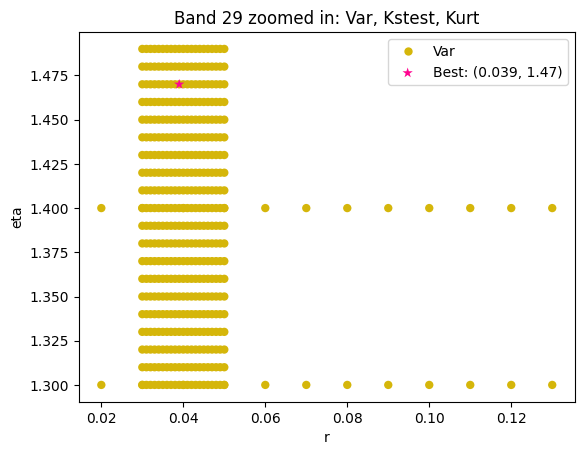

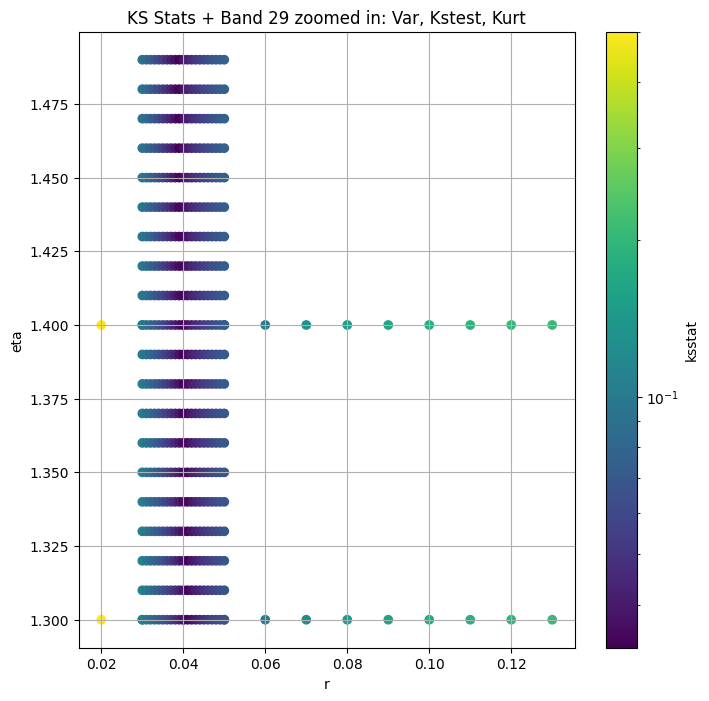

Band 32
(0.032, 2.77), 50 of 441
(0.034, 2.85), 100 of 441
(0.037, 2.72), 150 of 441
(0.039, 2.8), 200 of 441
(0.041, 2.88), 250 of 441
(0.044, 2.75), 300 of 441
(0.046, 2.83), 350 of 441
(0.049, 2.7), 400 of 441


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 441/441 [00:03<00:00, 119.13it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 32 best parameters: ((0.04, 2.75), 0.028631857499759716)


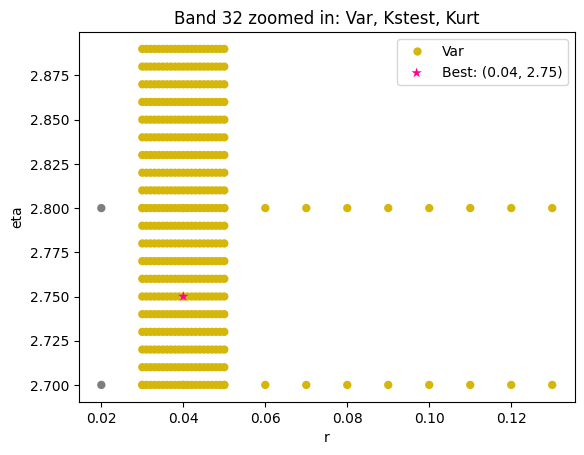

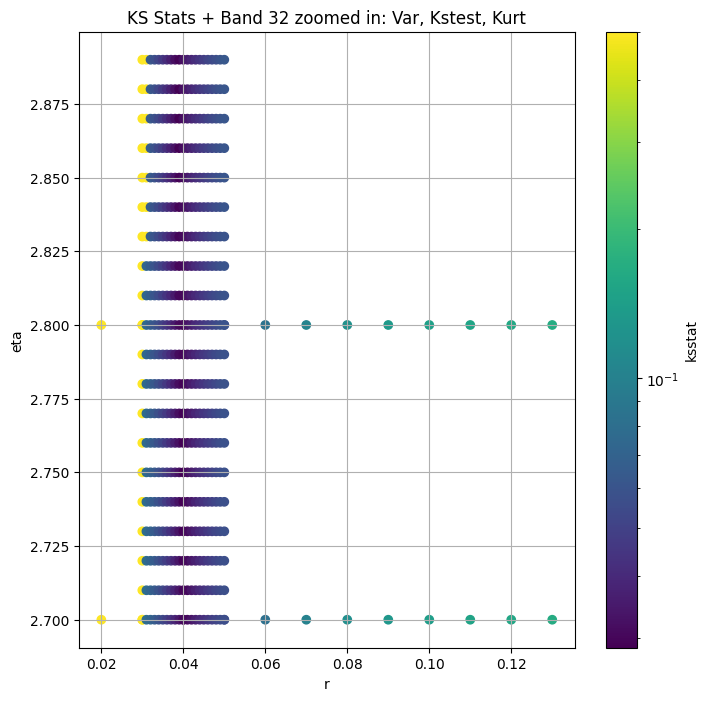

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       600.4443        45000.0       0.30         0.20   1.000000e+05  ...   
5      2060.5480       117000.0       0.30        -0.14   1.000000e+05  ...   
8      1727.8018       189000.0       0.35         0.00   1.000000e+05  ...   
11     6259.8403       495000.0       0.38         0.00   1.000000e+05  ...   
14     4860.0464      1134000.0       0.43         0.00   1.000000e+05  ...   
17     7685.5044      2574000.0       0.47        -0.10   1.000000e+05  ...   
20     6708.6846      5967000.0       0.49        -0.40   1.000000e+05  ...   
23     8285.5580     13887000.0       0.59        -0.60   1.000000e+05  ...   
26     9318.7330     31968000.0       0.90        -0.90   1.000000e+05  ...   
29     9072.5770     73701000.0       0.04         1.40   8.263222e-44  ...   
32     3932.4010     59634000.0       0.04         2.80   5.061535e-49  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2           47.550454          0.151043   0.295     0.110  1.000000e+05   
5           47.550454          0.084226   0.300    -0.142  1.000000e+05   
8       100000.000000          0.009754   0.343    -0.040  1.000000e+05   
11      100000.000000          0.006223   0.375    -0.050  1.000000e+05   
14      100000.000000          0.005925   0.420    -0.050  1.000000e+05   
17         314.108387          0.007456   0.461    -0.160  1.000000e+05   
20         698.907411          0.014870   0.486    -0.420  1.000000e+05   
23        2126.037470          0.023148   0.580    -0.610  1.000000e+05   
26        7081.851683          0.076868   0.891    -0.905  1.000000e+05   
29        7081.851683          0.254468   0.039     1.470  1.477521e-45   
32        7077.148189          0.361850   0.040     2.750  6.589828e-49   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.010110    0.295      0.110           0.010110        18984  
5             0.008935    0.300     -0.142           0.008935        21937  
8             0.007821    0.343     -0.040           0.007821        29898  
11            0.005919    0.375     -0.050           0.005919        52204  
14            0.004869    0.420     -0.050           0.004869        79734  
17            0.004940    0.461     -0.160           0.004940        76350  
20            0.006442    0.486     -0.420           0.006442        46617  
23            0.009093    0.580     -0.610           0.009093        22882  
26            0.012096    0.891     -0.905           0.012096        13168  
29            0.033076    0.039      1.470           0.033076         1686  
32            0.028632    0.040      2.750           0.028632         2301  

[11 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

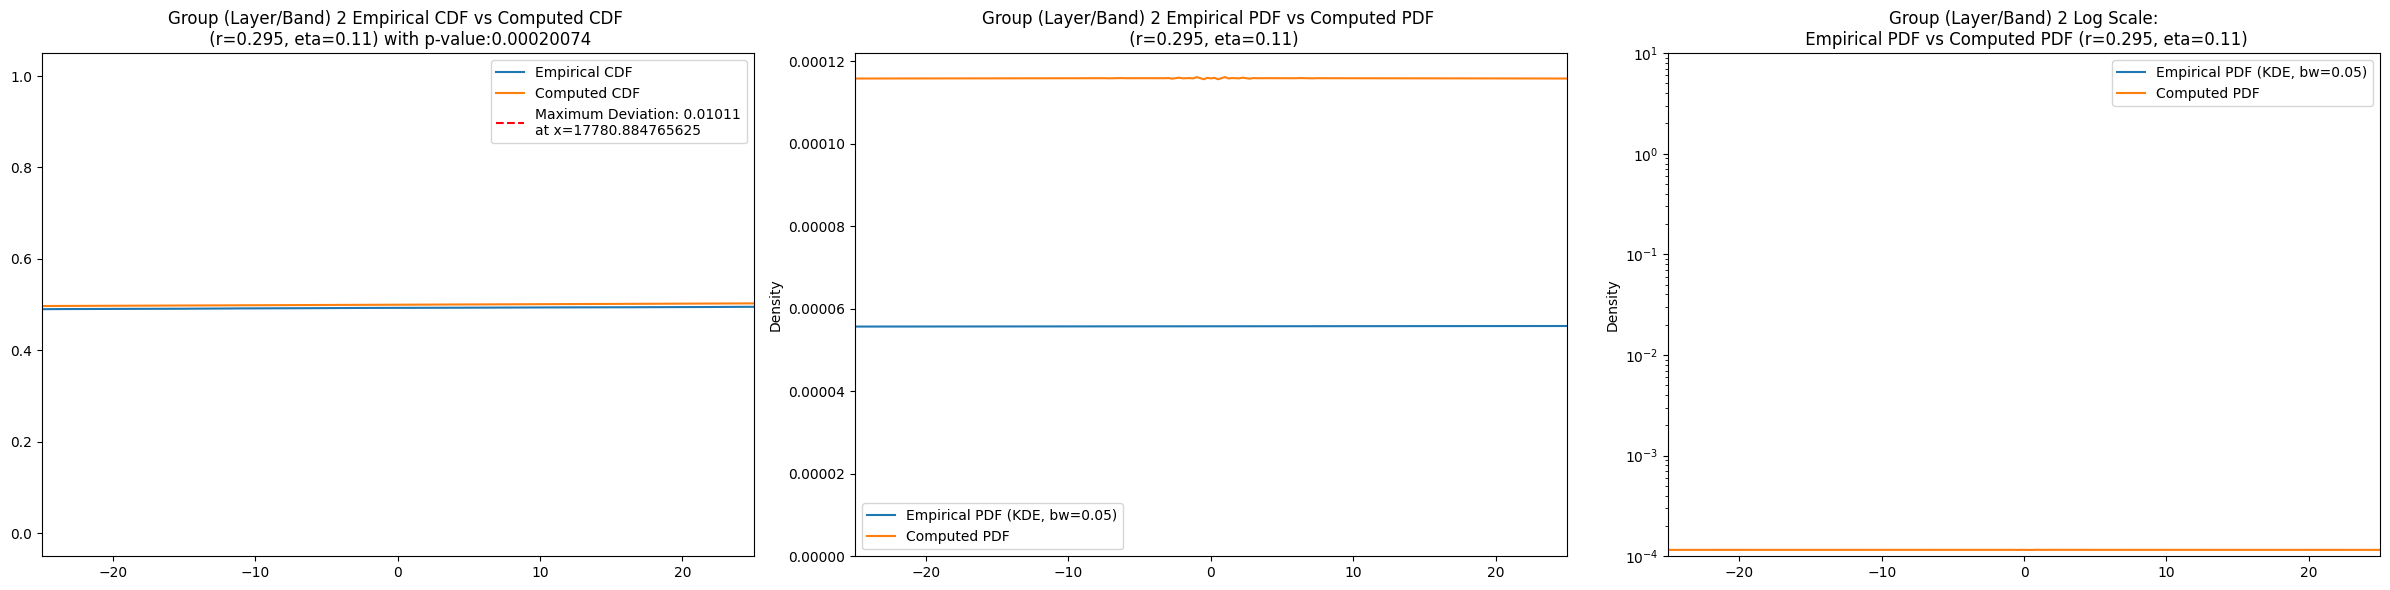

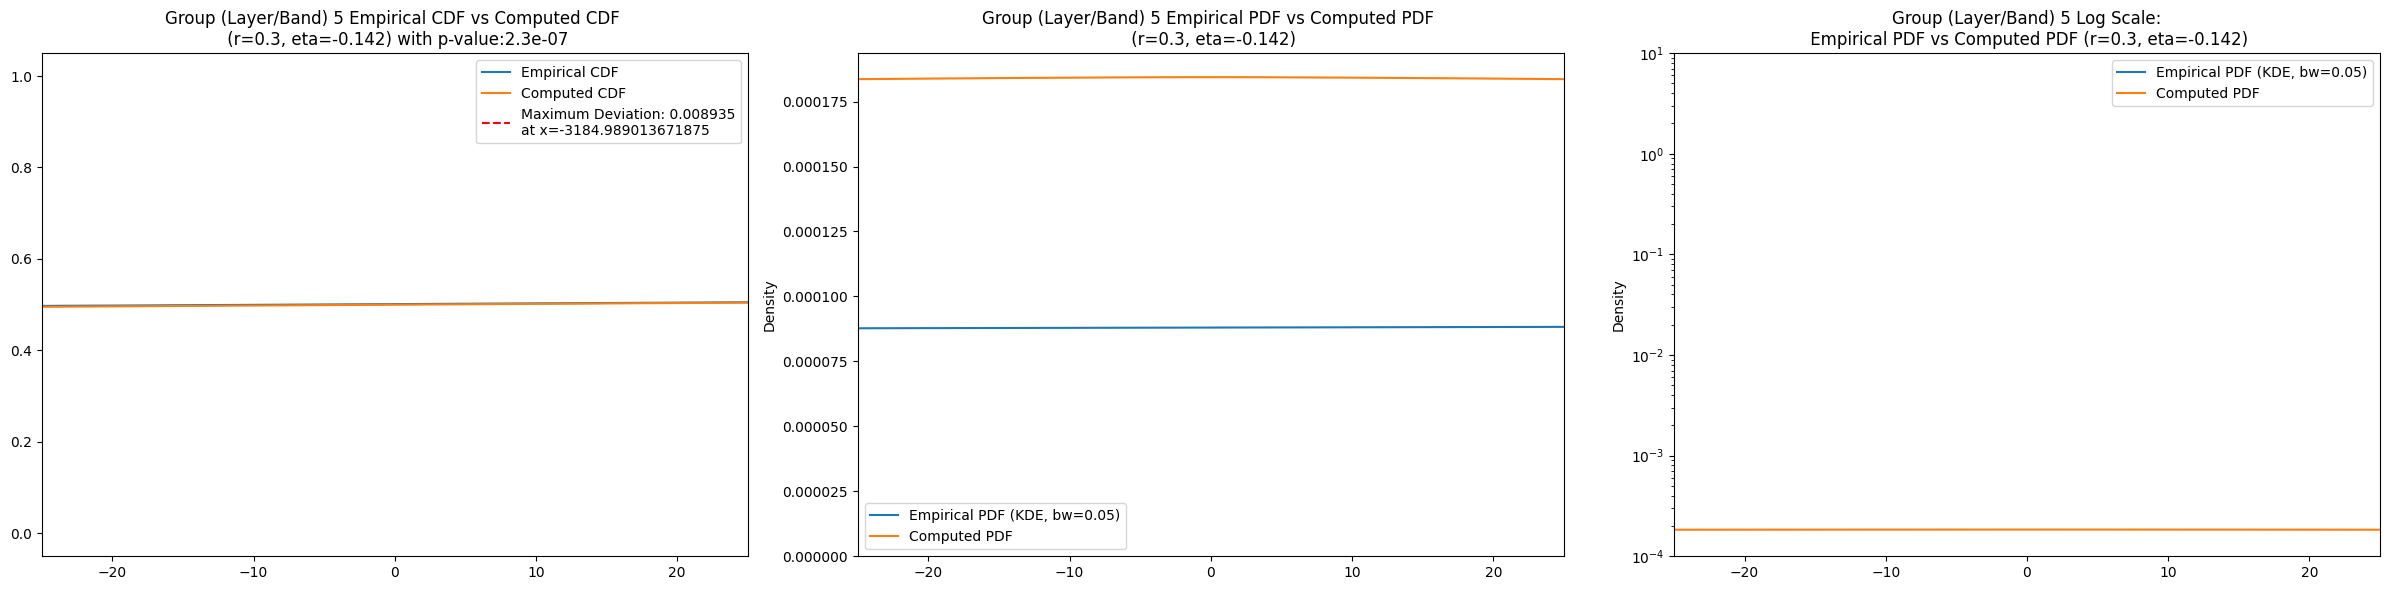

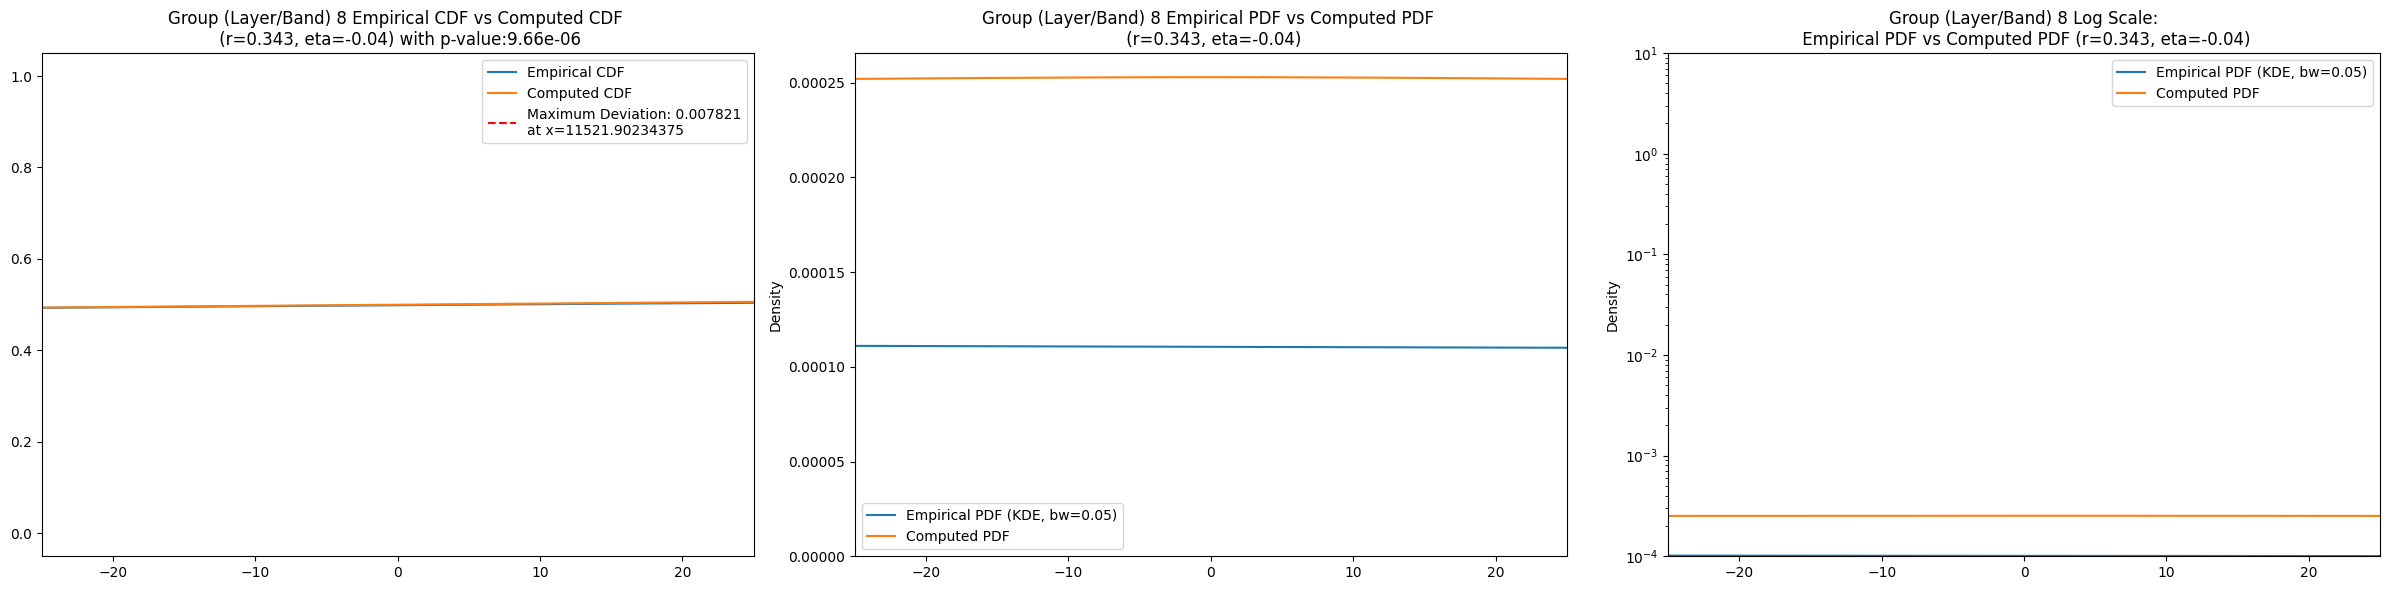

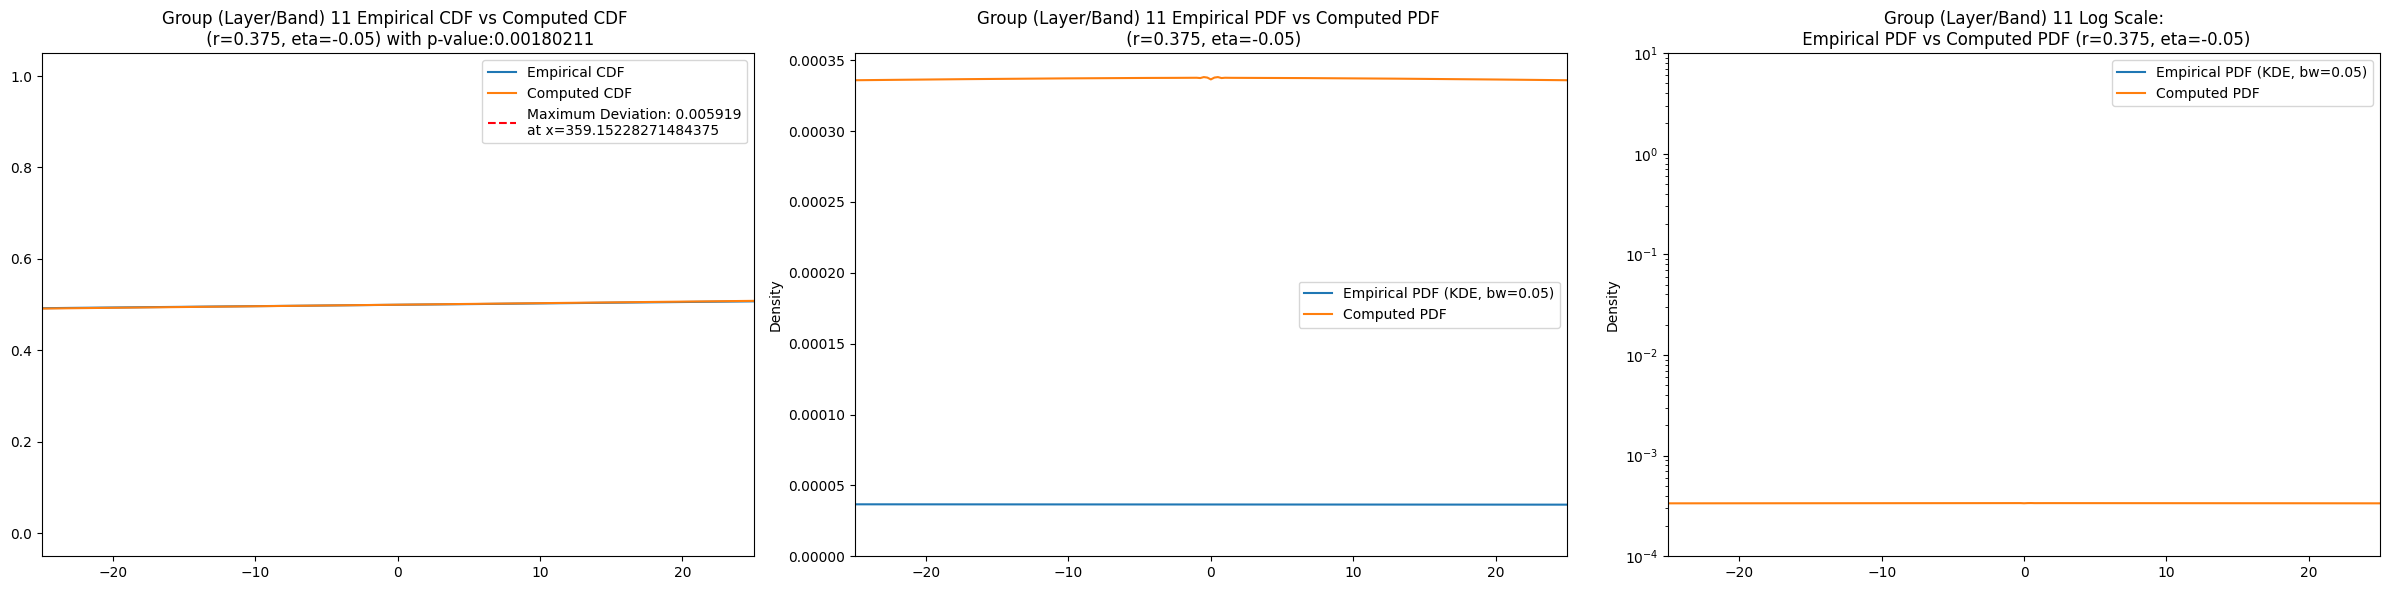

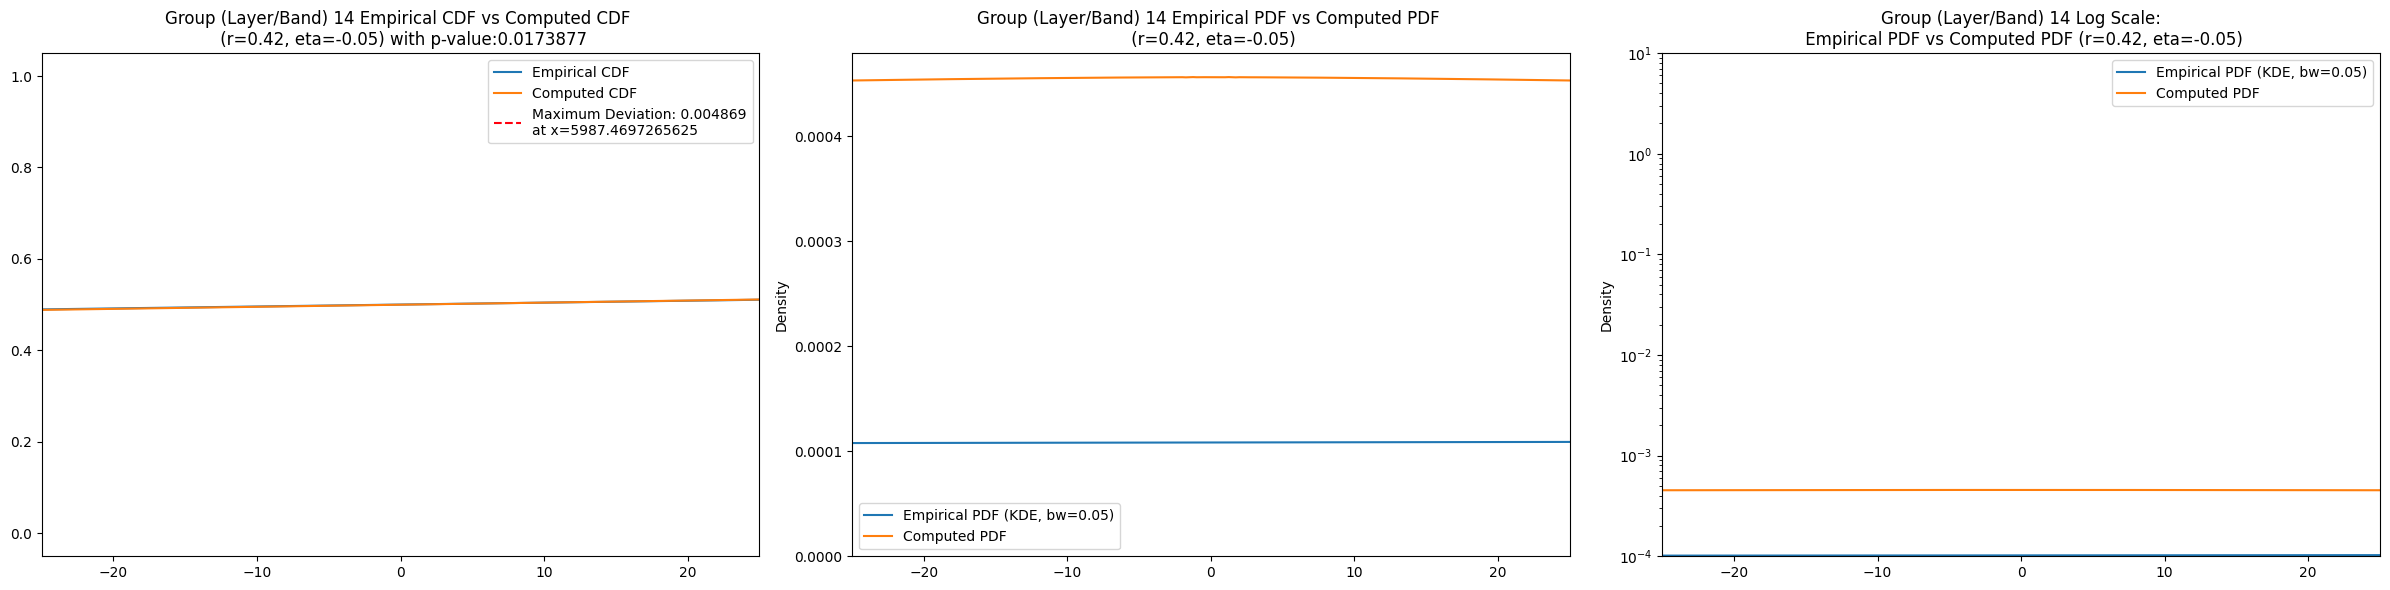

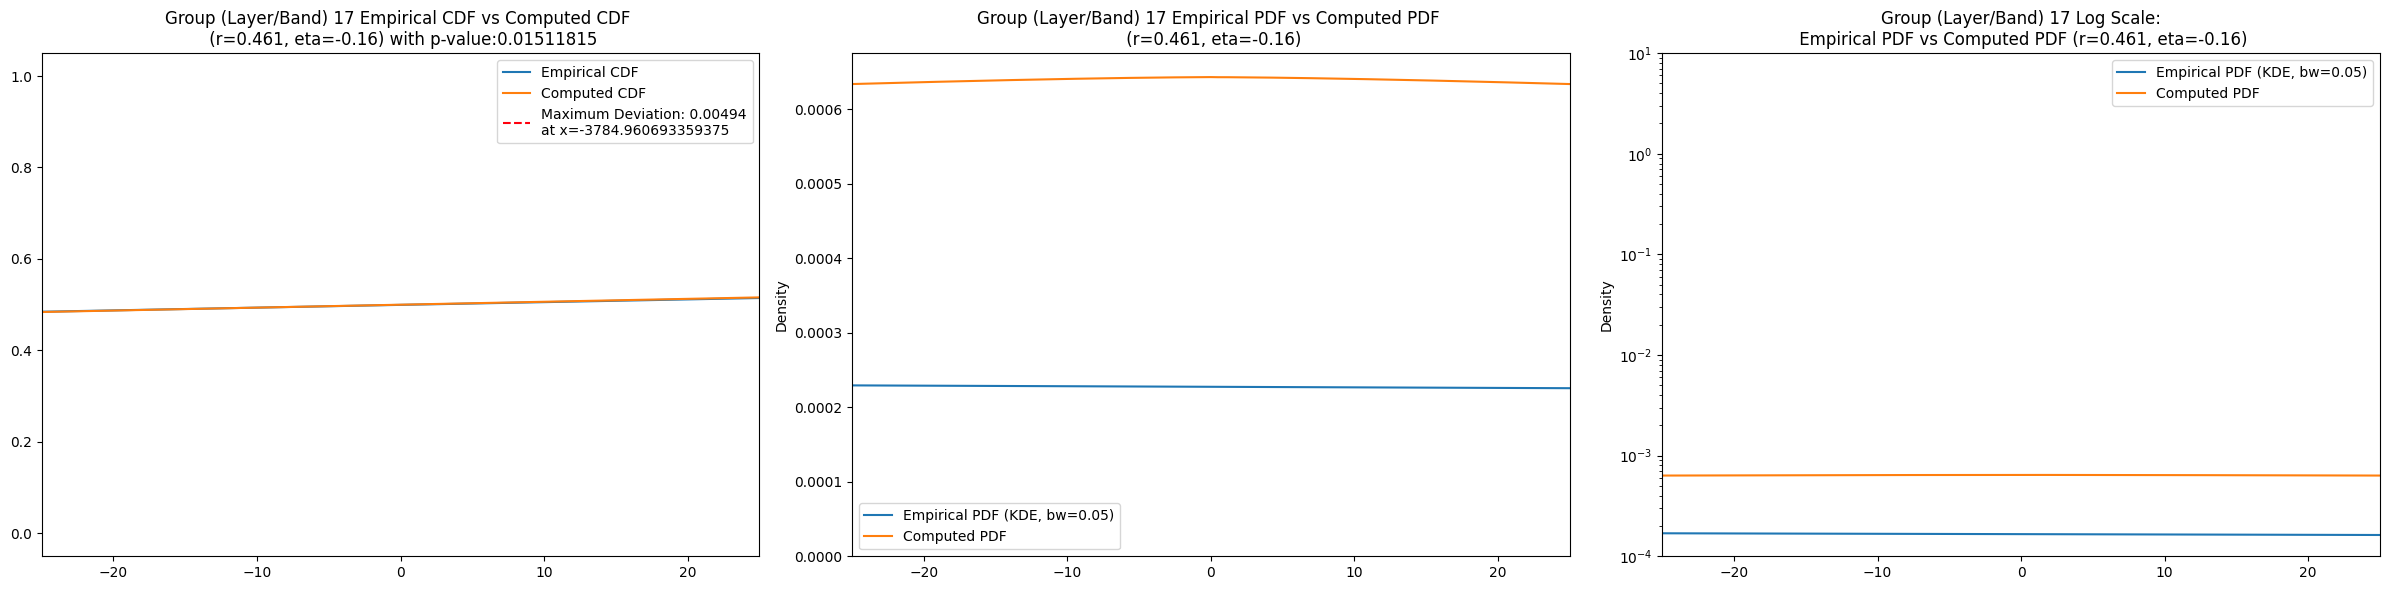

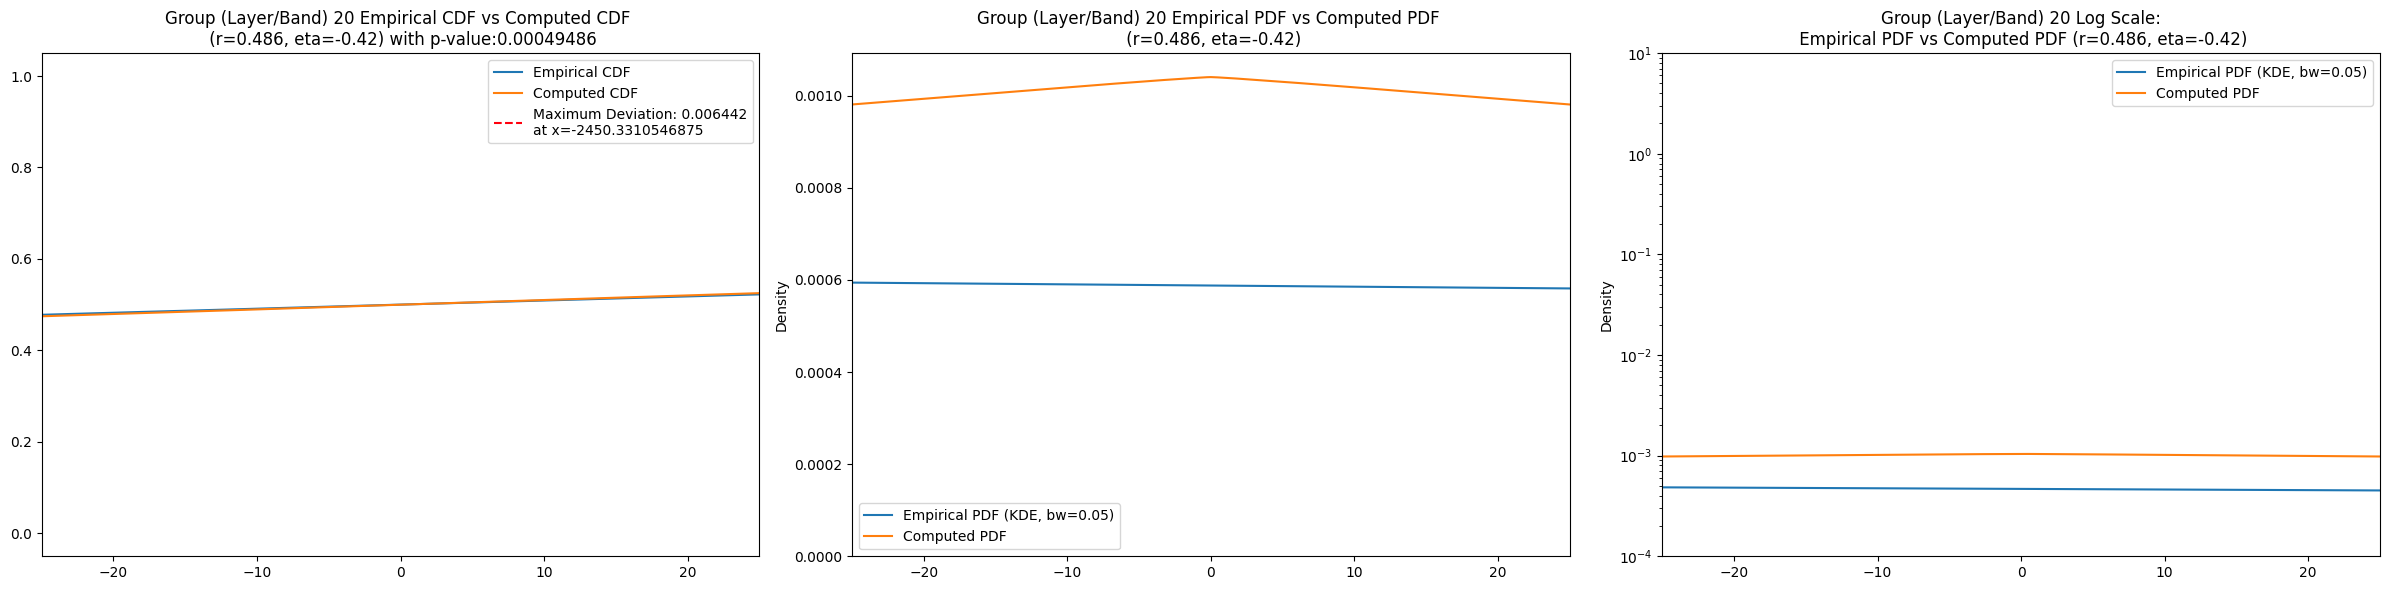

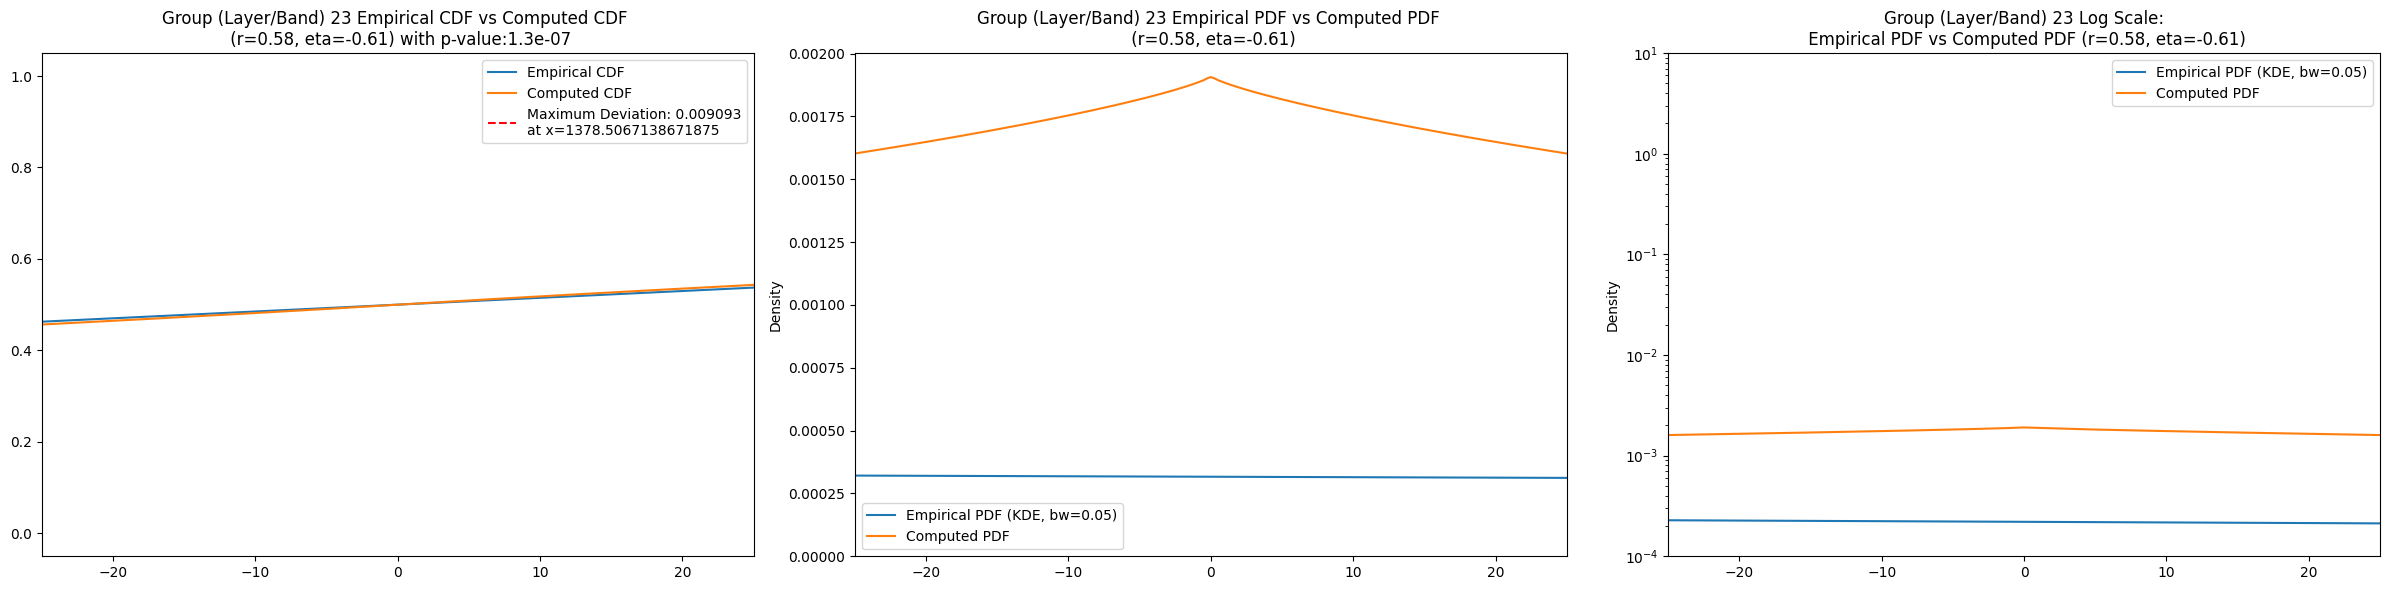

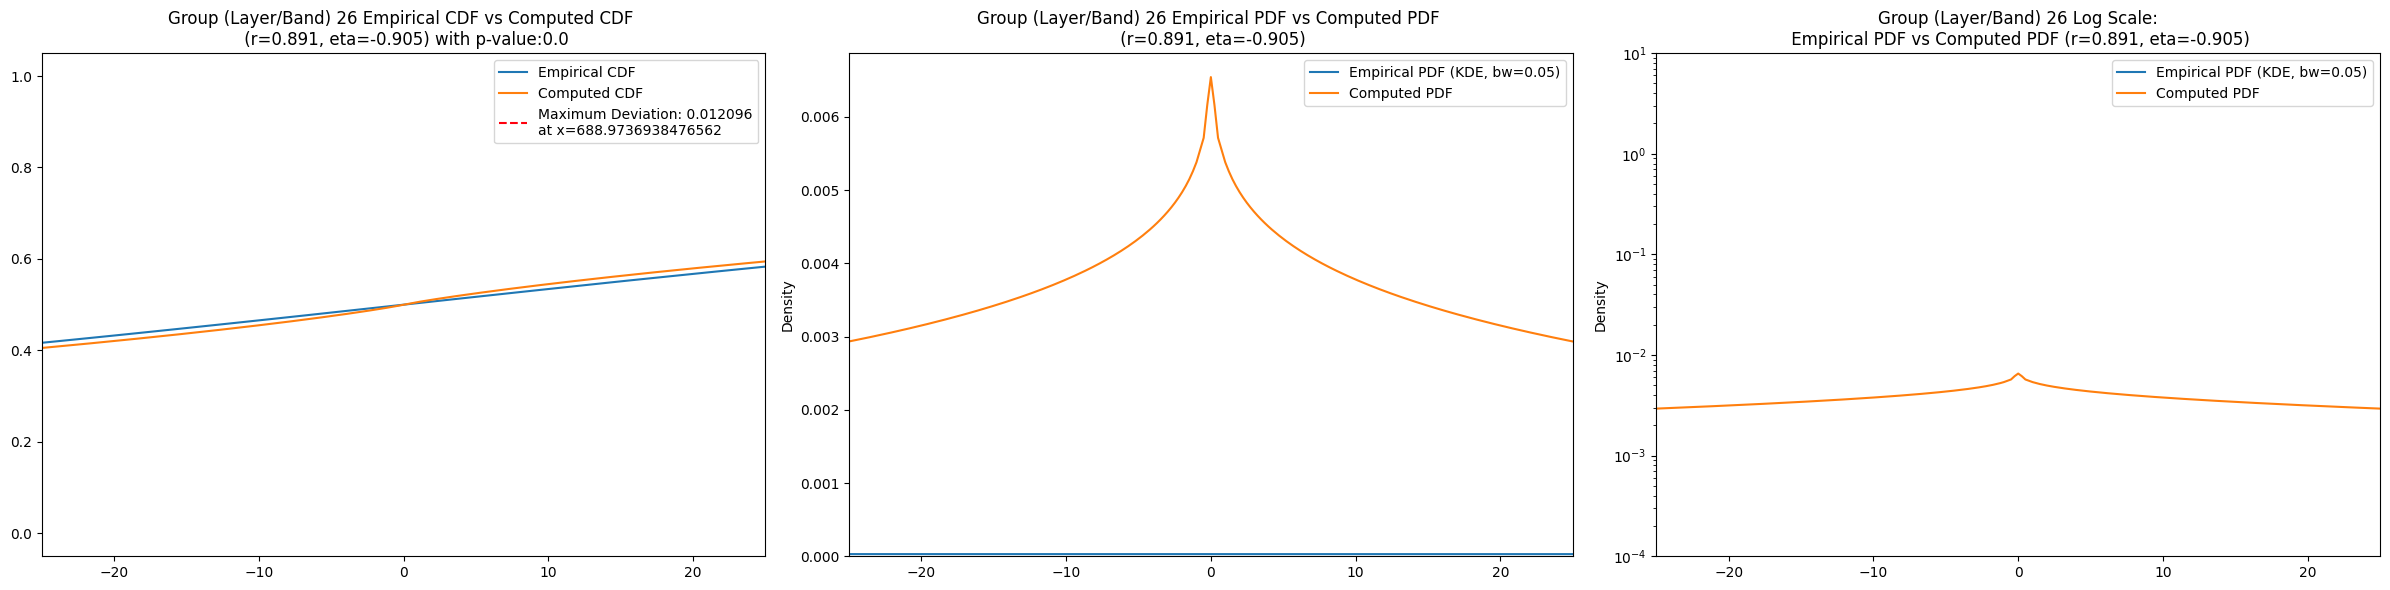

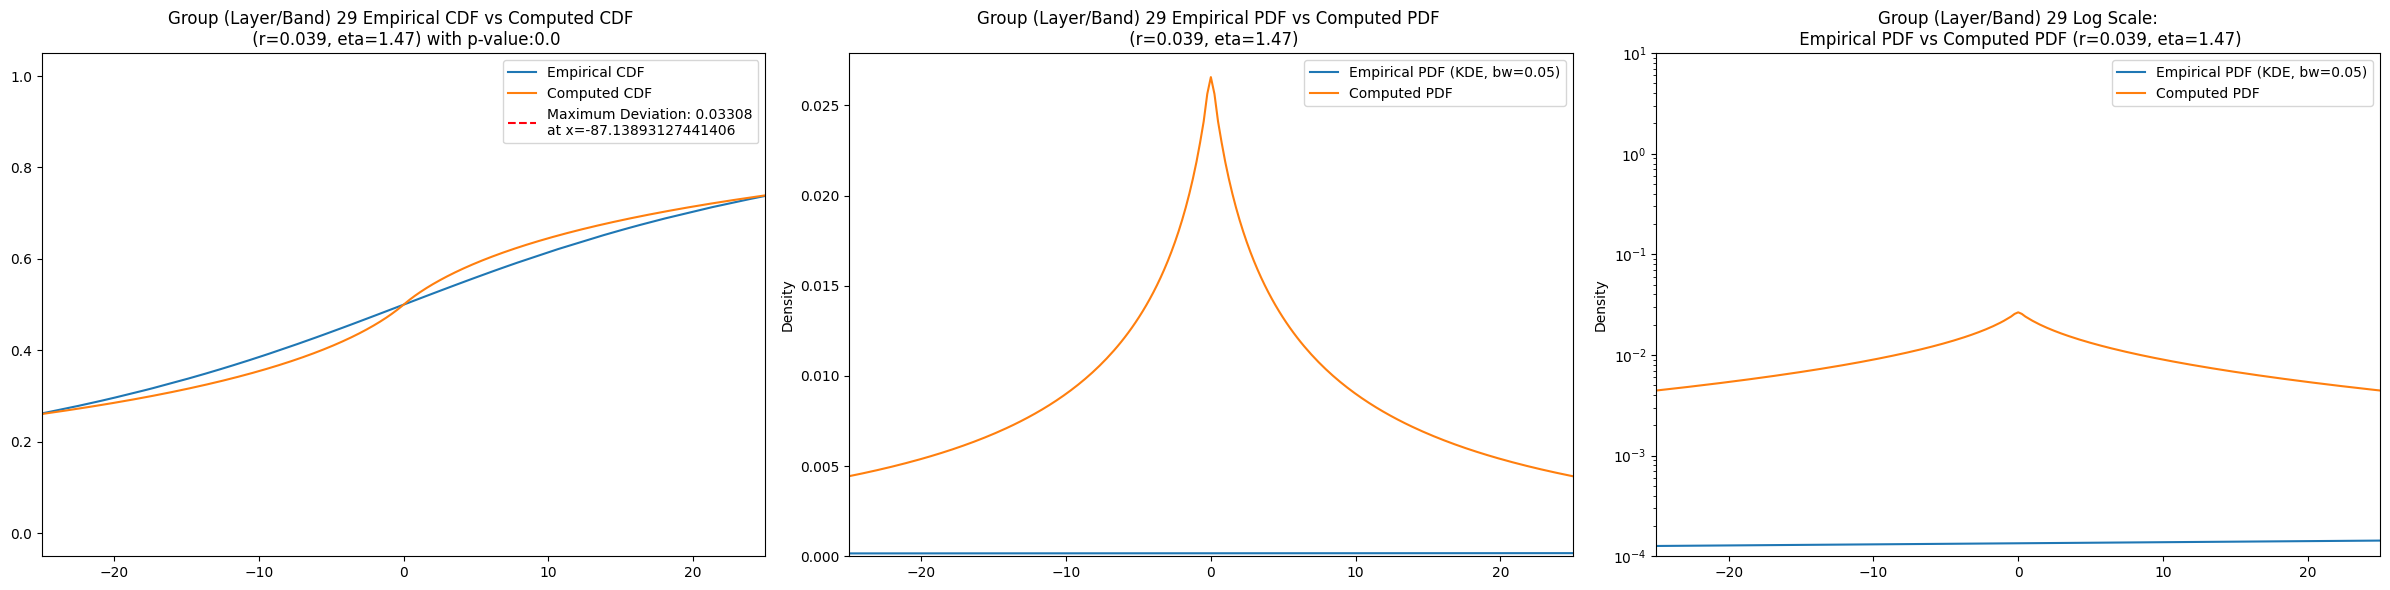

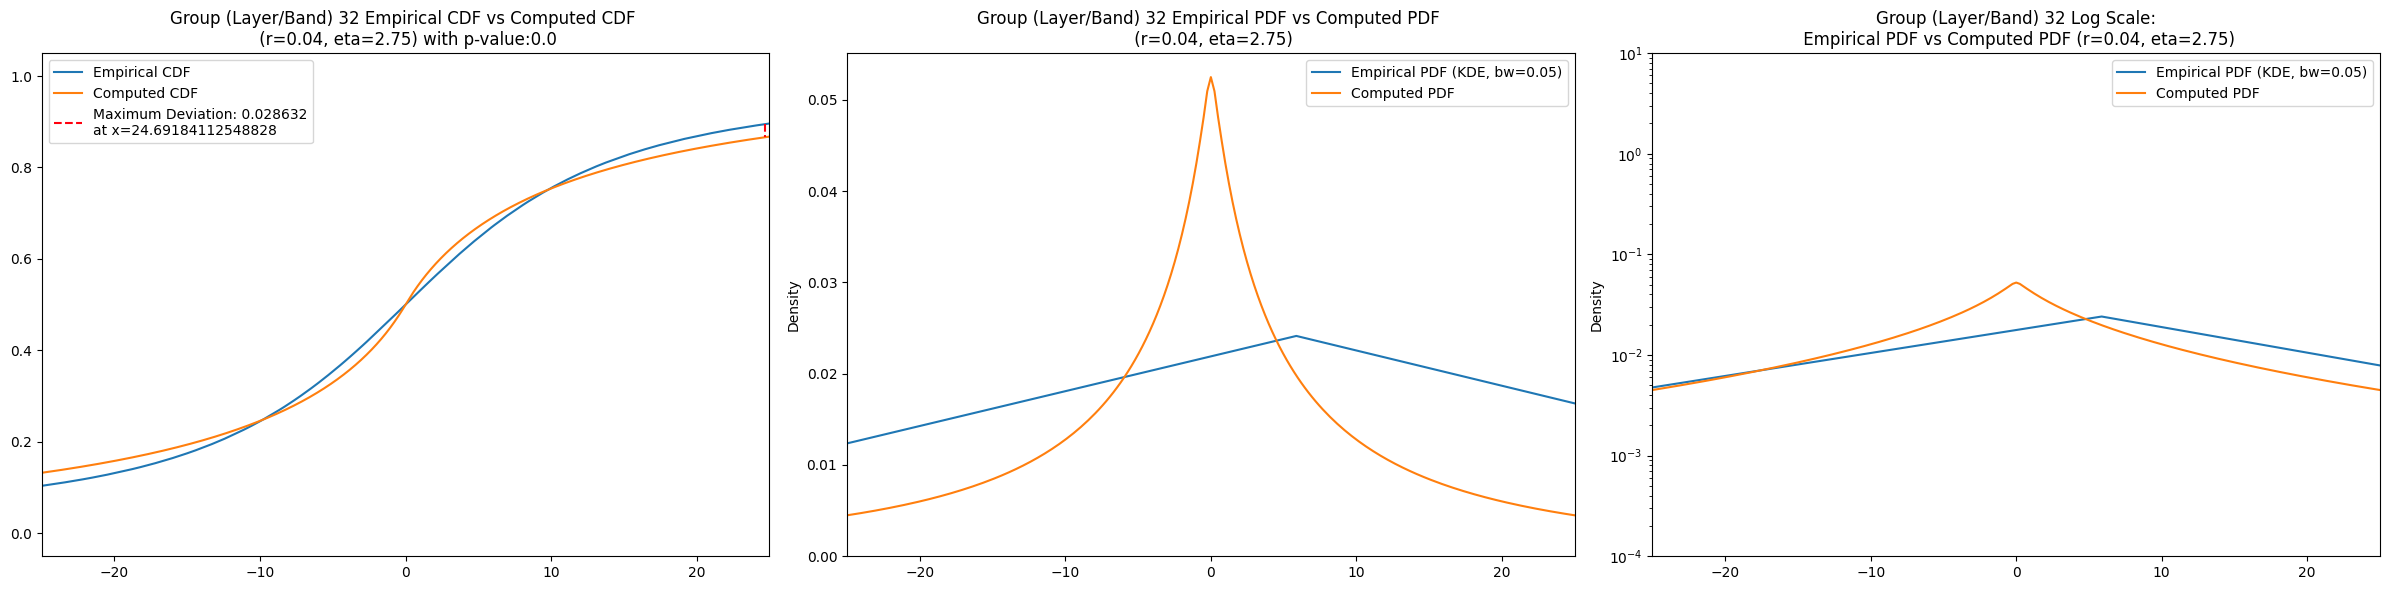

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       600.4443        45000.0       0.30         0.20   1.000000e+05  ...   
5      2060.5480       117000.0       0.30        -0.14   1.000000e+05  ...   
8      1727.8018       189000.0       0.35         0.00   1.000000e+05  ...   
11     6259.8403       495000.0       0.38         0.00   1.000000e+05  ...   
14     4860.0464      1134000.0       0.43         0.00   1.000000e+05  ...   
17     7685.5044      2574000.0       0.47        -0.10   1.000000e+05  ...   
20     6708.6846      5967000.0       0.49        -0.40   1.000000e+05  ...   
23     8285.5580     13887000.0       0.59        -0.60   1.000000e+05  ...   
26     9318.7330     31968000.0       0.90        -0.90   1.000000e+05  ...   
29     9072.5770     73701000.0       0.04         1.40   8.263222e-44  ...   
32     3932.4010     59634000.0       0.04         2.80   5.061535e-49  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          5228.2500              0.045990          3.791820e-83   
5          3625.8200              0.042807         9.710740e-187   
8          2415.7300              0.037672         1.751260e-233   
11         1768.9900              0.033941          0.000000e+00   
14         1255.2300              0.032912          0.000000e+00   
17          898.7480              0.034483          0.000000e+00   
20          623.3150              0.039409          0.000000e+00   
23          378.2960              0.042260          0.000000e+00   
26          177.8760              0.047941          0.000000e+00   
29           52.4803              0.055534          0.000000e+00   
32           18.2833              0.047946          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         4618.8700             0.020005         4.487170e-16  3666.4500   
5         3210.7000             0.018556         2.003500e-35  2556.8900   
8         2142.5300             0.014049         7.833270e-33  1699.5800   
11        1566.5100             0.010974         3.310420e-52  1254.9900   
14        1105.2500             0.008823         4.143350e-77   896.8090   
17         790.9840             0.009403        4.203400e-198   640.0720   
20         549.6240             0.014132         0.000000e+00   441.6110   
23         334.4700             0.017541         0.000000e+00   266.9490   
26         158.1580             0.022784         0.000000e+00   124.7820   
29          46.7800             0.030867         0.000000e+00    36.9039   
32          16.2233             0.025693         0.000000e+00    13.0003   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.01

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.585050e+08  1.589284e+08  4.078820e+08    356.08157   99.133300   
5     1.529785e+08  8.631151e+07  3.112997e+08    813.59064  103.779990   
8     5.121678e+07  3.003023e+07  9.583308e+07    612.80610   92.325806   
11    3.090617e+07  1.261454e+07  1.278532e+08   5769.23900   83.057900   
14    1.055680e+07  5.359151e+06  3.458285e+07   2610.08280   75.710780   
17    6.451851e+06  2.578068e+06  3.393685e+07  11181.92200   65.416466   
20    3.491903e+06  1.486023e+06  1.712065e+07   6724.62650   70.291565   
23    1.724653e+06  5.911003e+05  1.148688e+07  16738.59000   63.702858   
26    1.045736e+06  1.697875e+05  1.057094e+07  32596.10400   71.612460   
29    1.118847e+05  2.123627e+04  9.046389e+05  26453.19300   91.602455   
32    4.155727e+03  2.176440e+03  1.159914e+04   1816.90760   91.580090   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       600.4443        45000.0       0.30         0.20   1.000000e+05  ...   
5      2060.5480       117000.0       0.30        -0.14   1.000000e+05  ...   
8      1727.8018       189000.0       0.35         0.00   1.000000e+05  ...   
11     6259.8403       495000.0       0.38         0.00   1.000000e+05  ...   
14     4860.0464      1134000.0       0.43         0.00   1.000000e+05  ...   
17     7685.5044      2574000.0       0.47        -0.10   1.000000e+05  ...   
20     6708.6846      5967000.0       0.49        -0.40   1.000000e+05  ...   
23     8285.5580     13887000.0       0.59        -0.60   1.000000e+05  ...   
26     9318.7330     31968000.0       0.90        -0.90   1.000000e+05  ...   
29     9072.5770     73701000.0       0.04         1.40   8.263222e-44  ...   
32     3932.4010     59634000.0       0.04         2.80   5.061535e-49  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          5228.2500              0.045990          3.791820e-83   
5          3625.8200              0.042807         9.710740e-187   
8          2415.7300              0.037672         1.751260e-233   
11         1768.9900              0.033941          0.000000e+00   
14         1255.2300              0.032912          0.000000e+00   
17          898.7480              0.034483          0.000000e+00   
20          623.3150              0.039409          0.000000e+00   
23          378.2960              0.042260          0.000000e+00   
26          177.8760              0.047941          0.000000e+00   
29           52.4803              0.055534          0.000000e+00   
32           18.2833              0.047946          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         4618.8700             0.020005         4.487170e-16  3666.4500   
5         3210.7000             0.018556         2.003500e-35  2556.8900   
8         2142.5300             0.014049         7.833270e-33  1699.5800   
11        1566.5100             0.010974         3.310420e-52  1254.9900   
14        1105.2500             0.008823         4.143350e-77   896.8090   
17         790.9840             0.009403        4.203400e-198   640.0720   
20         549.6240             0.014132         0.000000e+00   441.6110   
23         334.4700             0.017541         0.000000e+00   266.9490   
26         158.1580             0.022784         0.000000e+00   124.7820   
29          46.7800             0.030867         0.000000e+00    36.9039   
32          16.2233             0.025693         0.000000e+00    13.0003   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.01

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

PermissionError: [WinError 5] Access is denied: 'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\fourier\\approx1e5\\gray\\groupCDFs\\band11'